In [1]:
import sys, os
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import seaborn as sns
sns.set_style('white')

import geneinfo as gi
gi.email('your@email.com')

In [2]:
%env ftp_proxy http://proxy-default:3128
%env http_proxy http://proxy-default:3128
%env https_proxy http://proxy-default:3128

env: ftp_proxy=http://proxy-default:3128
env: http_proxy=http://proxy-default:3128
env: https_proxy=http://proxy-default:3128


In [3]:
def length_to_windows(length_df, pops, window_size=1000000):
    #pops = sorted(length_df["reference"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.length)//window_size
            if x == 0:
                overall_dict[row["reference"]][i] += int(row.length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["reference"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["reference"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["reference"]][i+x] += int(row.length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def create_paint_df_ind(df, ind, mapping, ns_map):
    d = {}
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

In [4]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"

In [5]:
input_file = rfmix_path + "all_chrX.msp.tsv"
chrX = pd.read_csv(input_file, sep = "\t", header=1)
file = open(input_file, 'r')
line1 = file.readline()
file.close()

In [6]:
number_subpop_mapping = {}
for subpop in line1.strip().split("\t"):
    # Splitting to create lists containing two values - subpop and number.
    subpop_number = subpop.split(": ")[-1].split("=")
    number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
# North is 1, South is 0
north_south_mapping = {'Hamadryas, Ethiopia': 1, 'Papio, Senegal': 1, 'Kindae, Zambia': 0, 'Ursinus, Zambia': 0}

In [7]:
df_l = []
for hap in chrX.columns[6:]:
    df_l.append(create_paint_df_ind(chrX, hap, number_subpop_mapping, north_south_mapping))
length_df_X = pd.concat(df_l)

In [8]:
sampling_locations_c = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].C_origin.unique()
sampling_locations_o = meta_data_samples.loc[meta_data_samples.Species.isin(["cynocephalus", "anubis"])].Origin.unique()


In [9]:
location_l = []
for sampling_location in sampling_locations_c:
    samples = meta_data_samples.loc[(meta_data_samples.C_origin == sampling_location)].PGDP_ID
    s_df = length_df_X.loc[length_df_X.individual.isin(samples)]
    s_df = s_df.groupby(["pos"])[["n/s", "length"]].mean().reset_index()
    s_df["Origin"] = sampling_location
    #s_df["C_origin"] = sampling_locations_c
    
    location_l.append(s_df)
location_df_X = pd.concat(location_l)

In [10]:
location_df_X.to_csv(rfmix_path + "chrX_summary_df.txt")

In [11]:
location_df_X

pos  n/s    length                          Origin
0       2500194  0.0   20174.0  Cynocephalus, Central Tanzania
1       2520368  0.0   18700.0  Cynocephalus, Central Tanzania
2       2539068  0.0   34526.0  Cynocephalus, Central Tanzania
3       2573594  0.0    1336.0  Cynocephalus, Central Tanzania
4       2574930  0.0   14436.0  Cynocephalus, Central Tanzania
...         ...  ...       ...                             ...
7283  143085438  1.0    4621.0                Anubis, Ethiopia
7284  143090059  1.0   12501.0                Anubis, Ethiopia
7285  143102560  1.0  124649.0                Anubis, Ethiopia
7286  143227209  1.0  411301.0                Anubis, Ethiopia
7287  143638510  1.0   24533.0                Anubis, Ethiopia

[36440 rows x 4 columns]

In [12]:
loc_df = location_df_X
olive_tanzania = loc_df.loc[loc_df.Origin == "Anubis, Tanzania"]
eastern_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Central Tanzania"]
western_yellow = loc_df.loc[loc_df.Origin == "Cynocephalus, Western Tanzania"]

In [13]:
# USed when clustering by Origin instead of C_origin
loc_df = location_df_X

serengeti = loc_df.loc[loc_df.Origin == "Serengeti, Tanzania"]
tarangire = loc_df.loc[loc_df.Origin == "Tarangire, Tanzania"]
gog = loc_df.loc[loc_df.Origin == "Gog Woreda, Gambella region, Ethiopia"]
gombe = loc_df.loc[loc_df.Origin == "Gombe, Tanzania"]
mikumi = loc_df.loc[loc_df.Origin == "Mikumi, Tanzania"]
ruaha = loc_df.loc[loc_df.Origin == "Ruaha, Tanzania"]
mahale = loc_df.loc[loc_df.Origin == "Mahale, Tanzania"]
issa = loc_df.loc[loc_df.Origin == "Issa Valley, Tanzania"]
manyara = loc_df.loc[loc_df.Origin == "Lake Manyara, Tanzania"]
katavi = loc_df.loc[loc_df.Origin == "Katavi, Tanzania"]

<Axes: xlabel='pos', ylabel='n/s'>

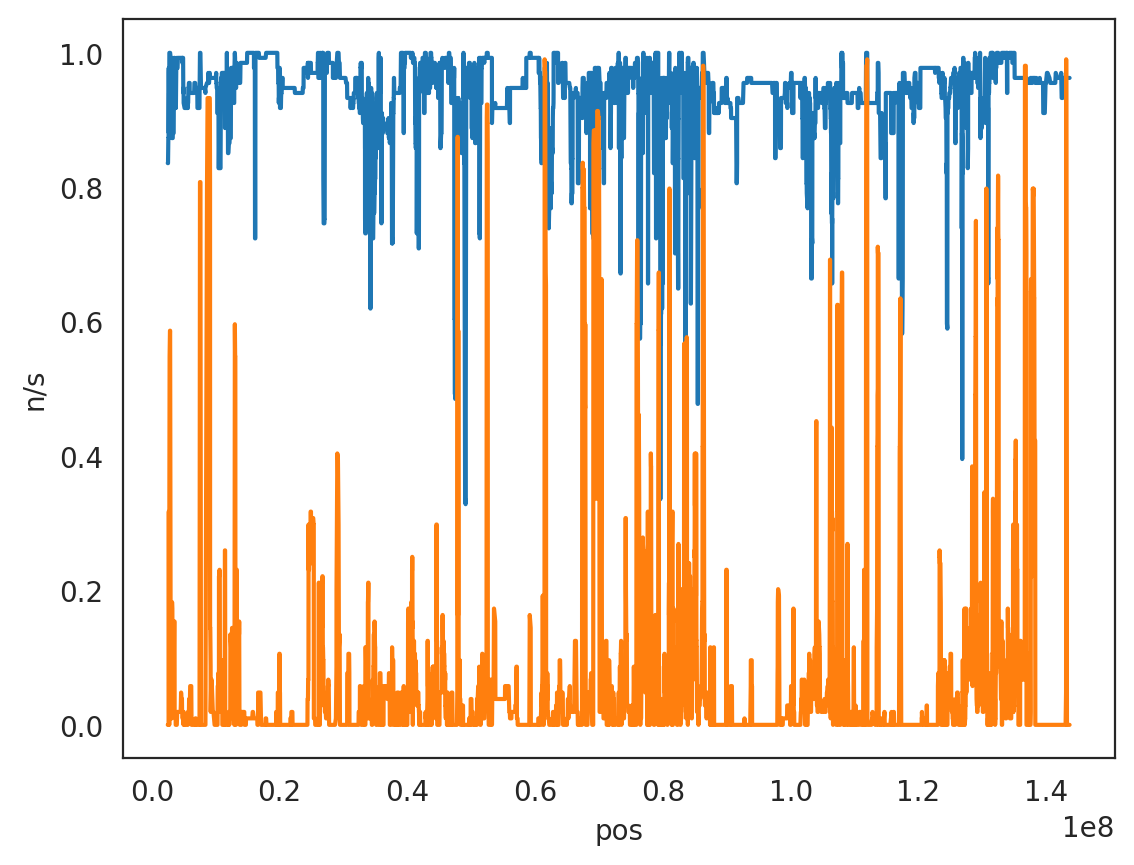

In [14]:
sns.lineplot(x = olive_tanzania.pos, y = olive_tanzania["n/s"])
sns.lineplot(x = eastern_yellow.pos, y = eastern_yellow["n/s"])
#sns.lineplot(x = western_yellow.pos, y = western_yellow["n/s"])

<Axes: xlabel='pos', ylabel='n/s'>

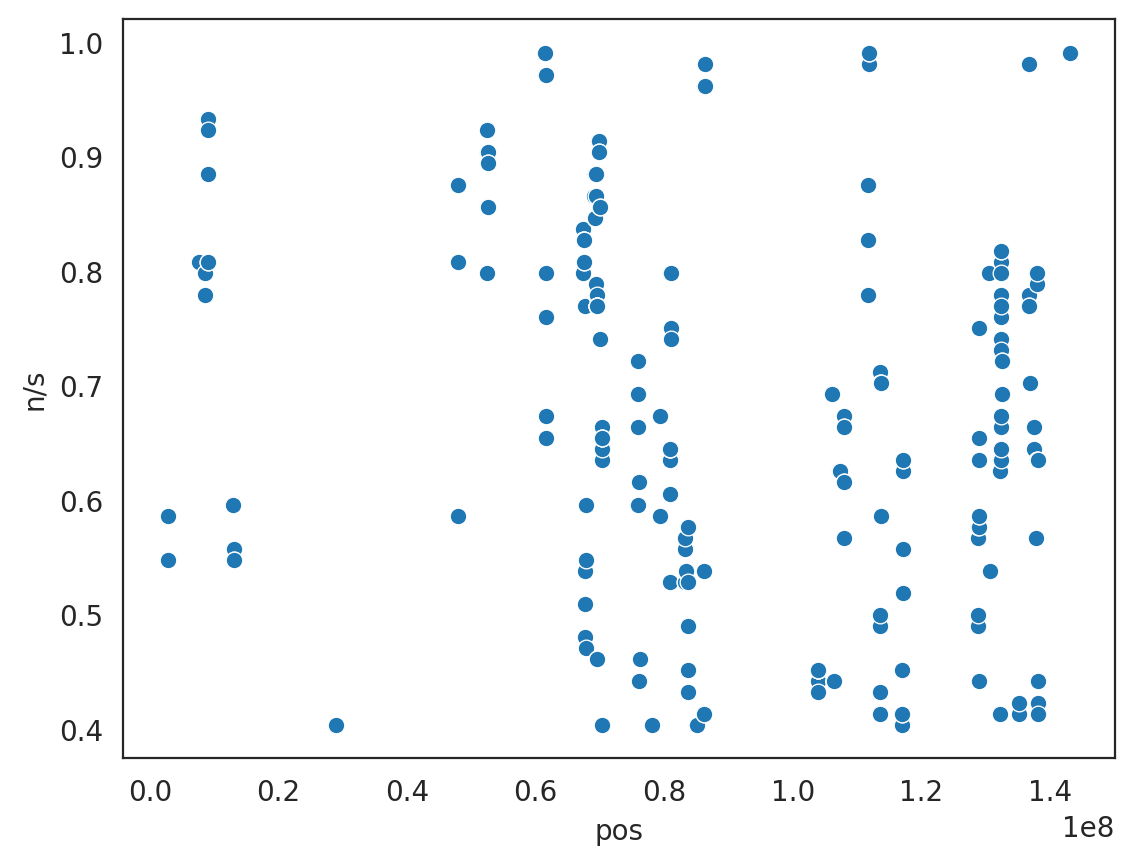

In [15]:
sub_eastern = eastern_yellow.loc[eastern_yellow["n/s"] > 0.4]
sns.scatterplot(data = sub_eastern, x="pos", y="n/s")

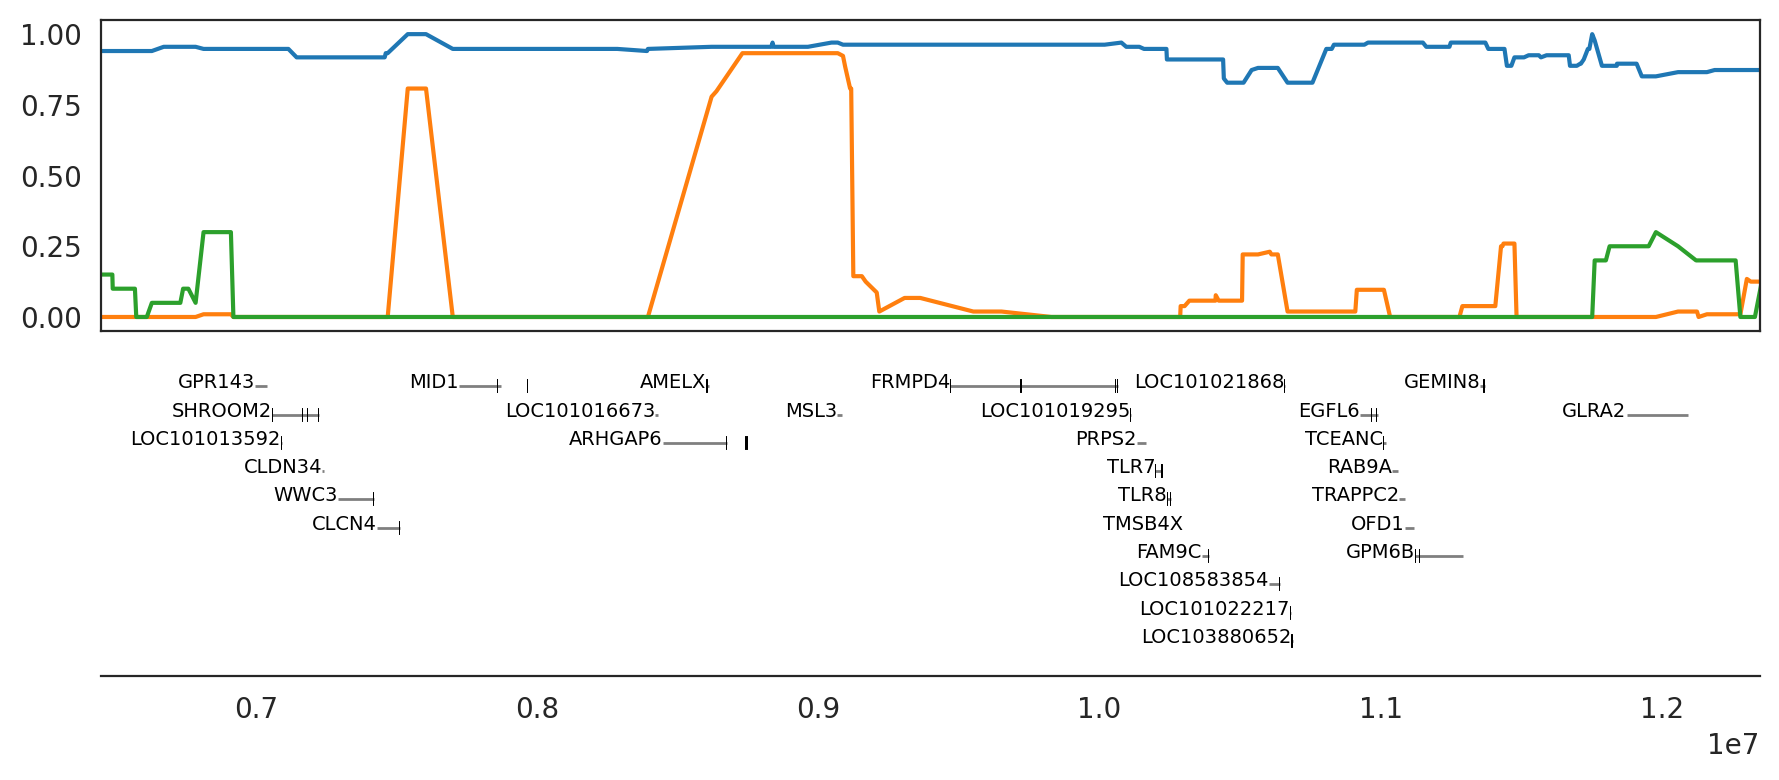

In [115]:
ax = gi.gene_plot('chrX', 7000000, 12000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
ax.plot(western_yellow.pos, western_yellow["n/s"])
plt.tight_layout()

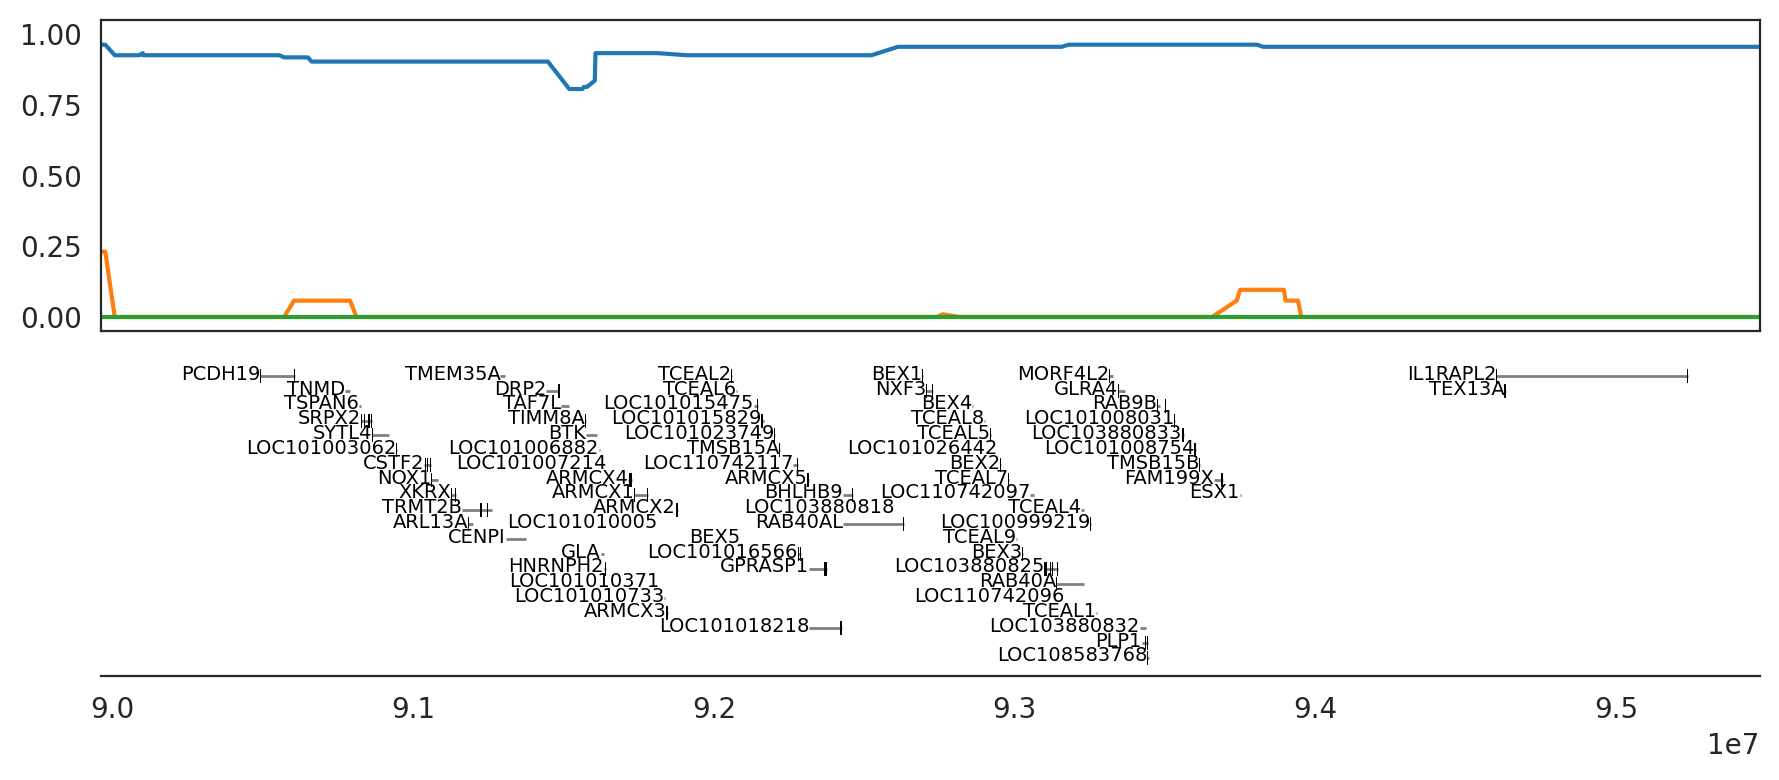

In [17]:
ax = gi.gene_plot('chrX', 90000000, 95000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
ax.plot(western_yellow.pos, western_yellow["n/s"])

plt.tight_layout()

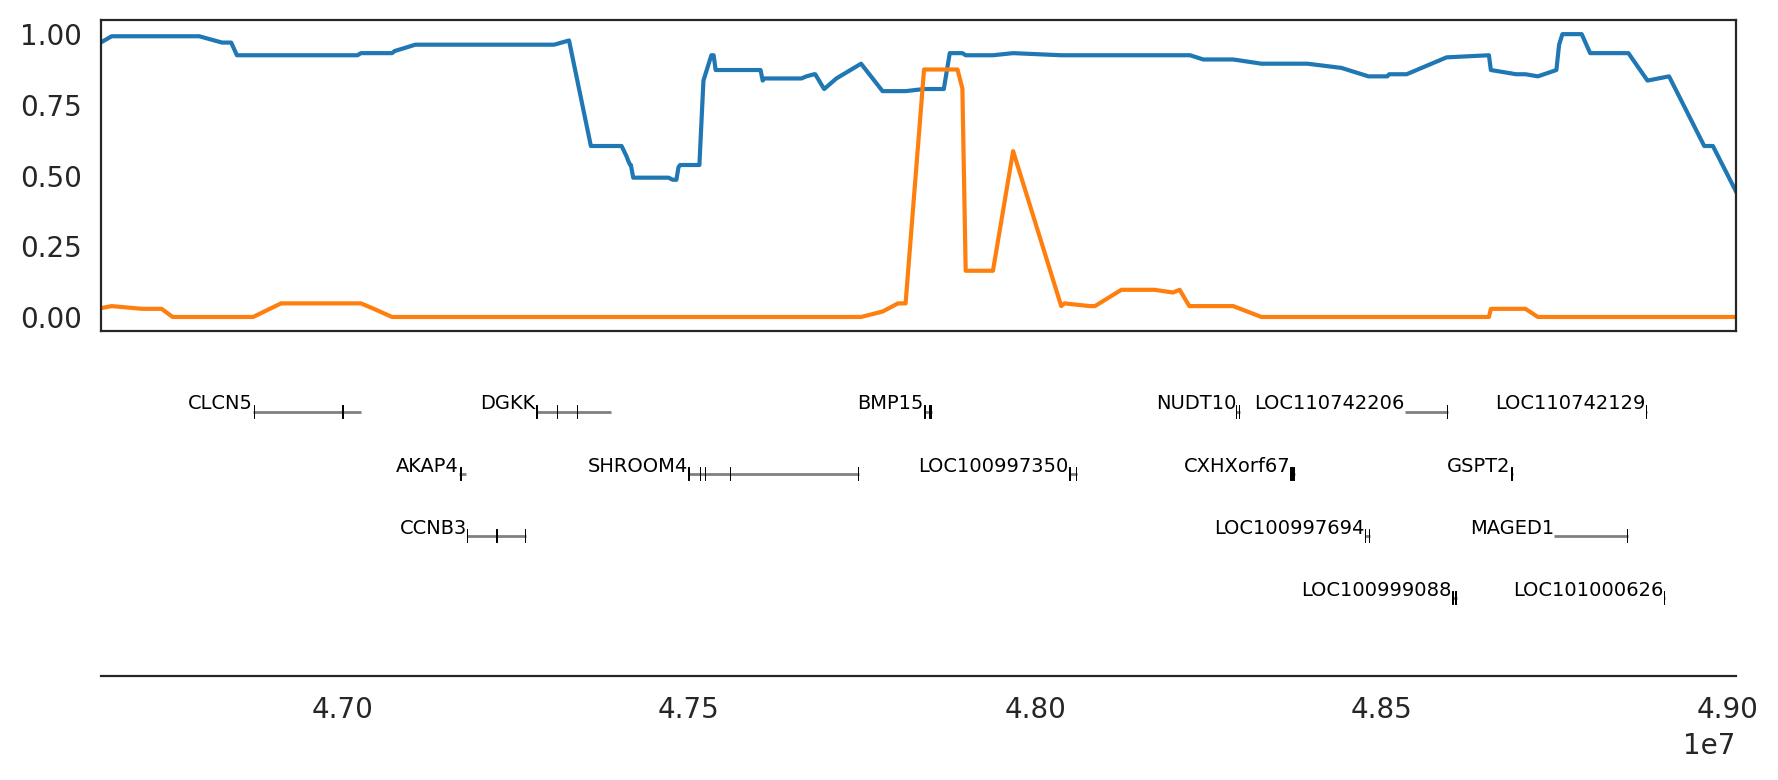

In [18]:
ax = gi.gene_plot('chrX', 47000000, 49000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

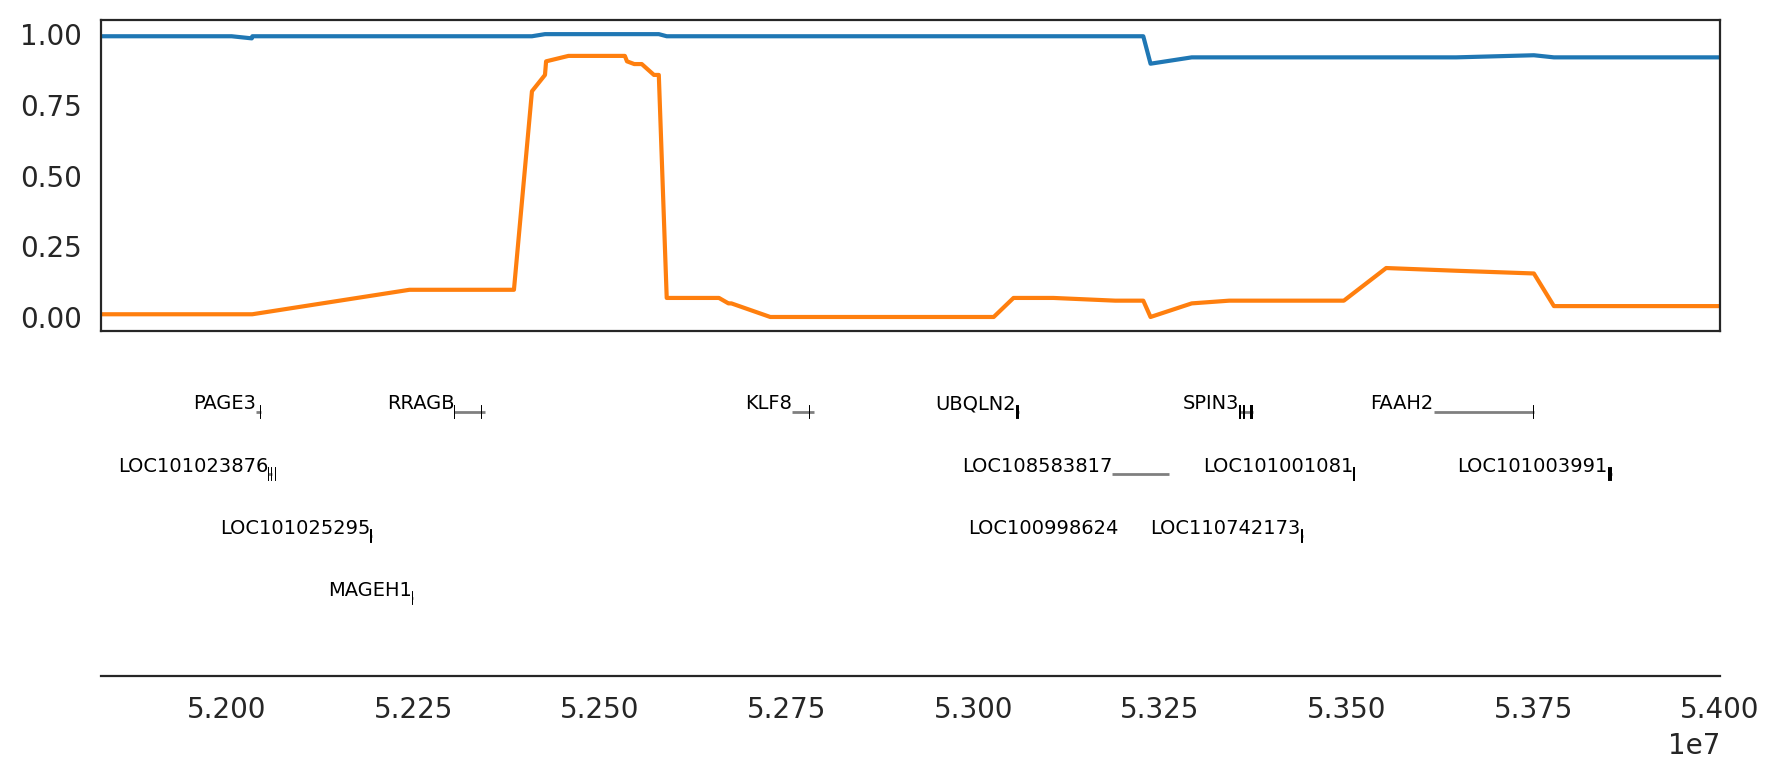

In [19]:
ax = gi.gene_plot('chrX', 52000000, 54000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

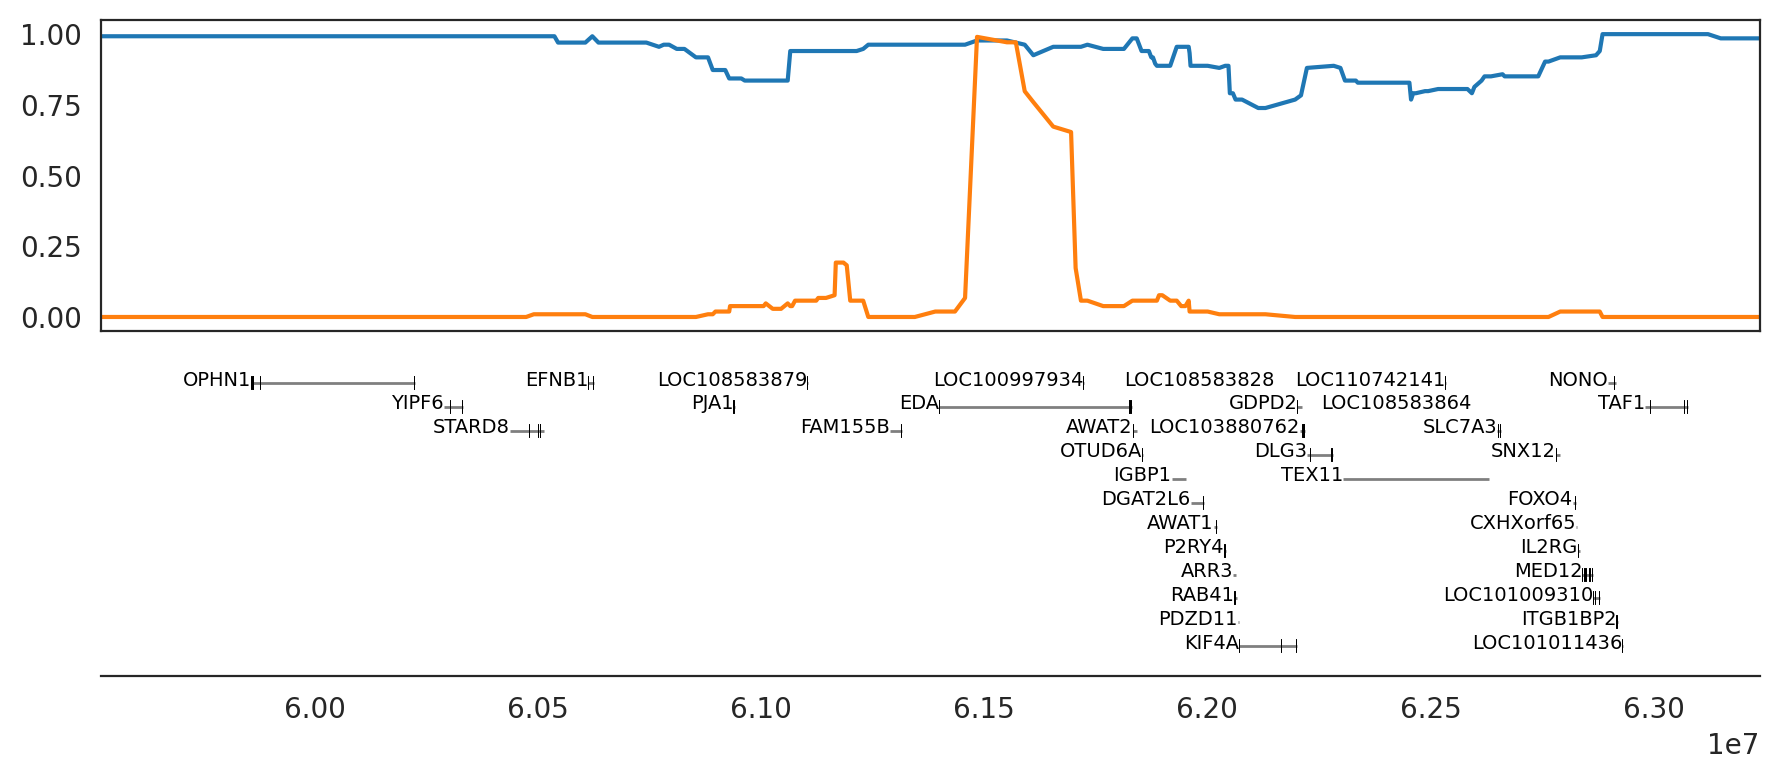

In [20]:
ax = gi.gene_plot('chrX', 60000000, 63000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

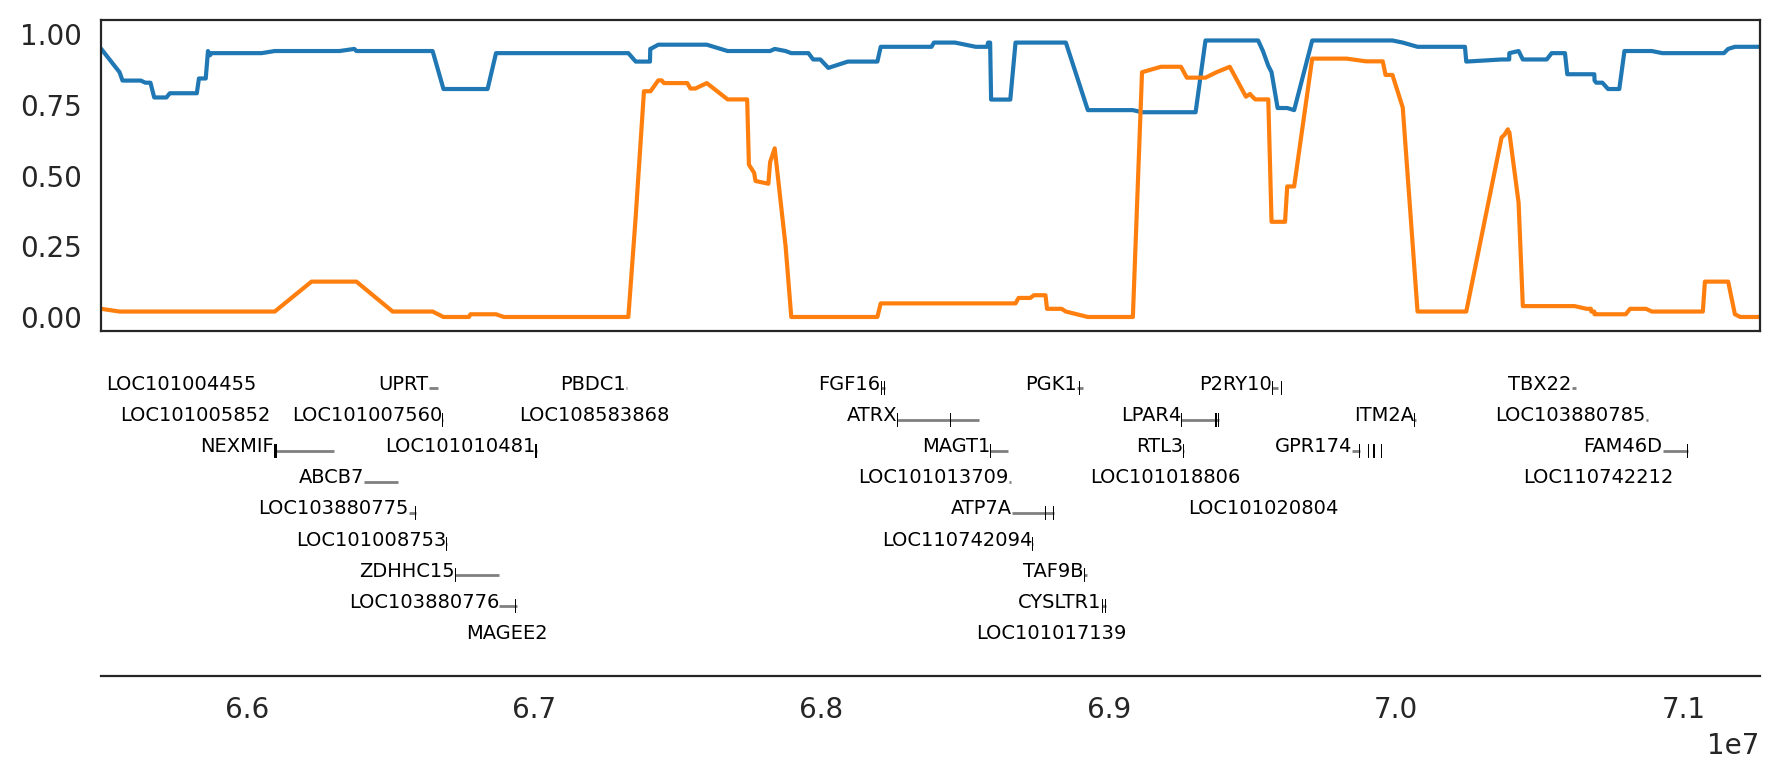

In [21]:
ax = gi.gene_plot('chrX', 66000000, 71000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

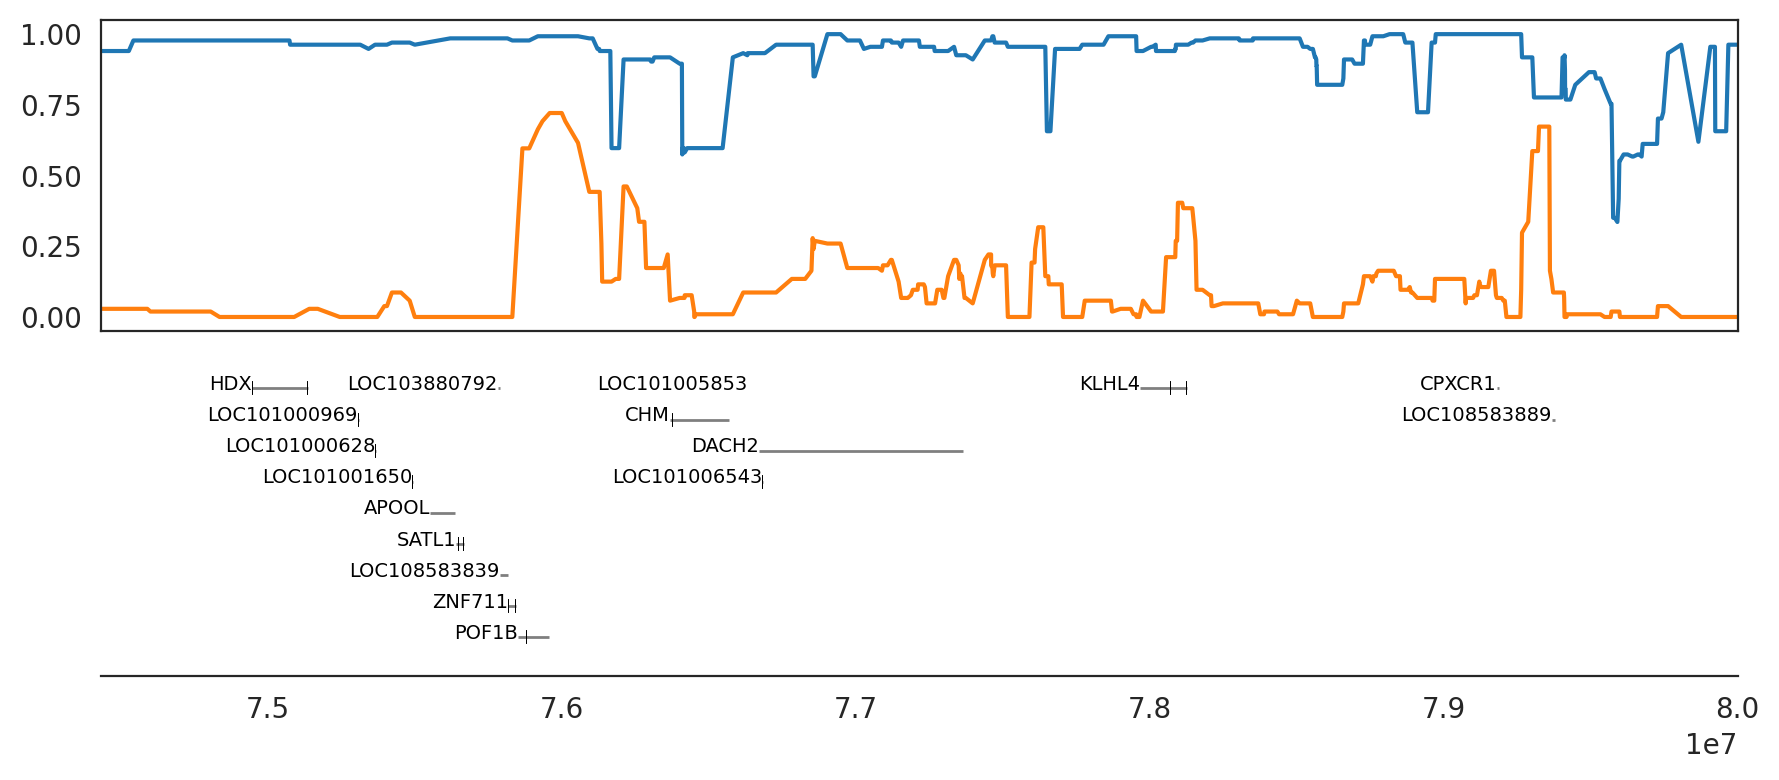

In [22]:
ax = gi.gene_plot('chrX', 75000000, 80000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

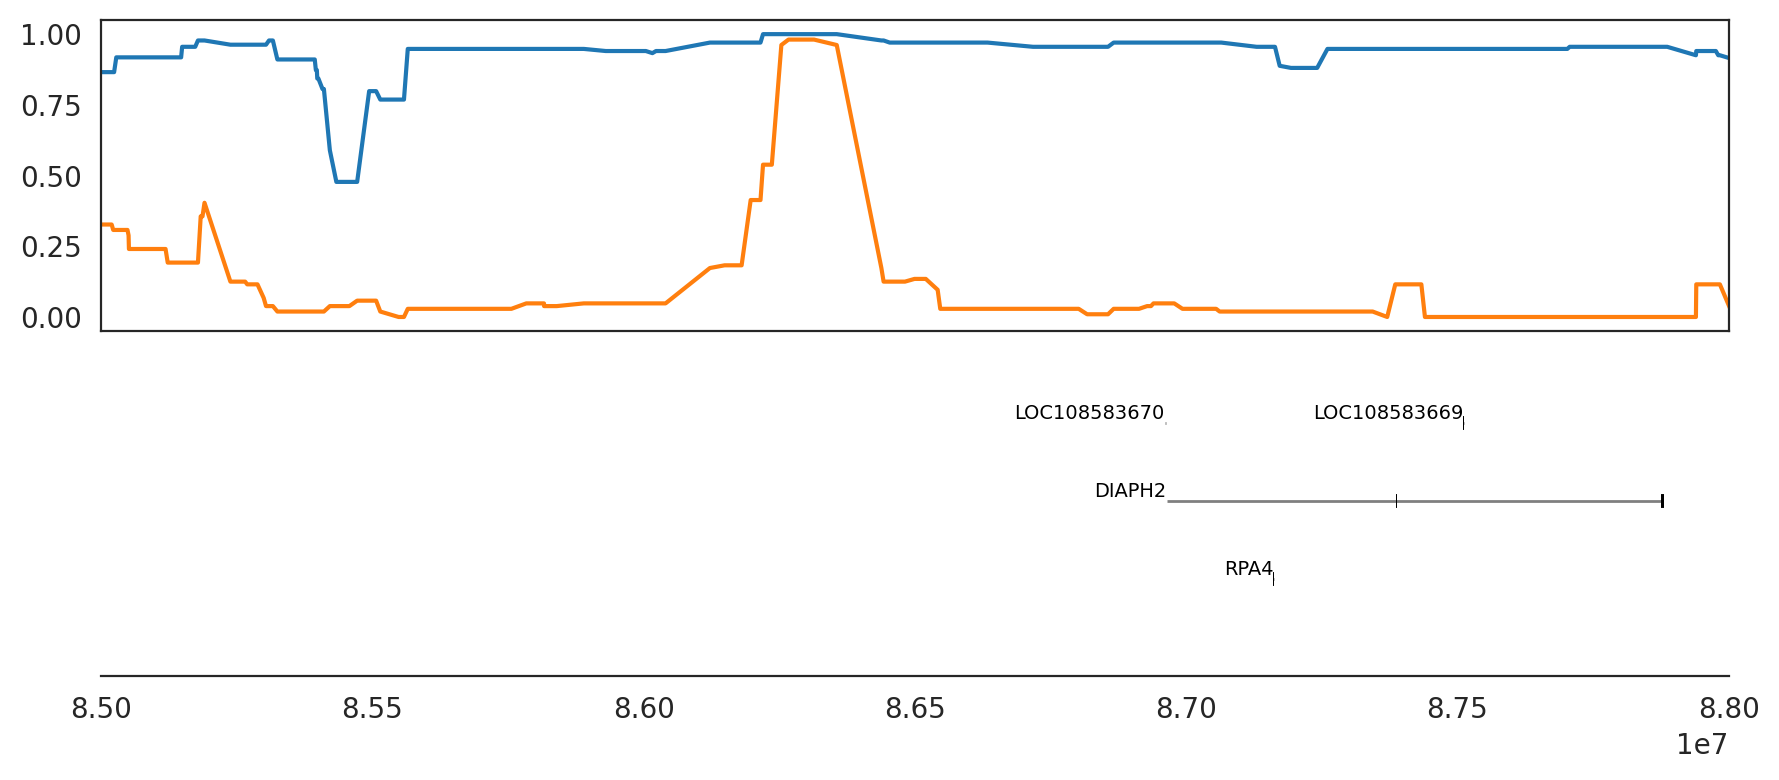

In [23]:
ax = gi.gene_plot('chrX', 85000000, 88000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

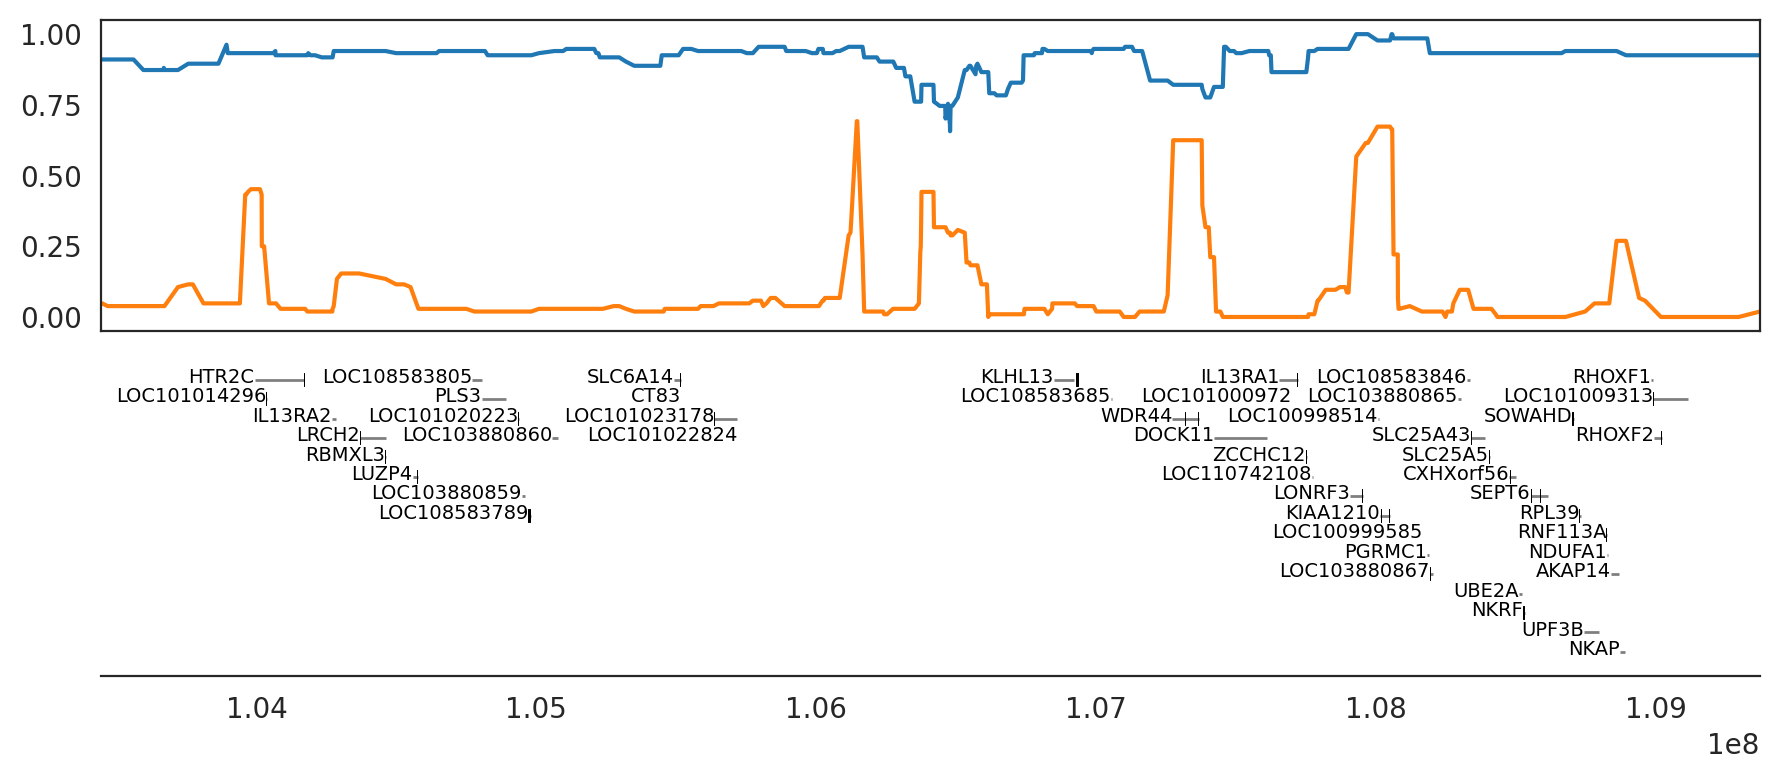

In [24]:
ax = gi.gene_plot('chrX', 104000000, 109000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

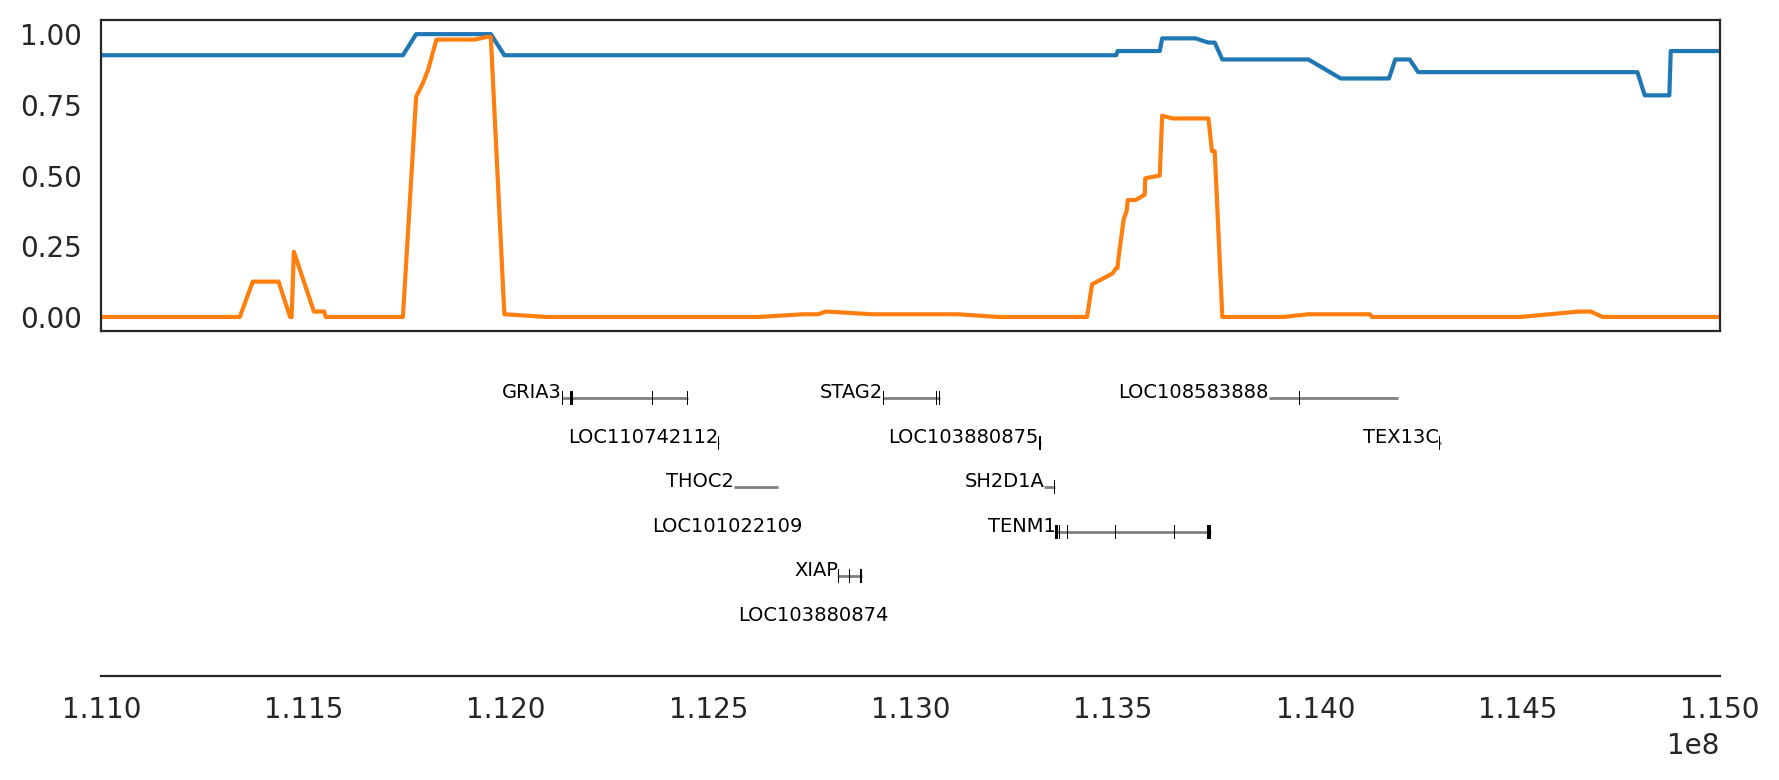

In [25]:
ax = gi.gene_plot('chrX', 111000000, 115000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

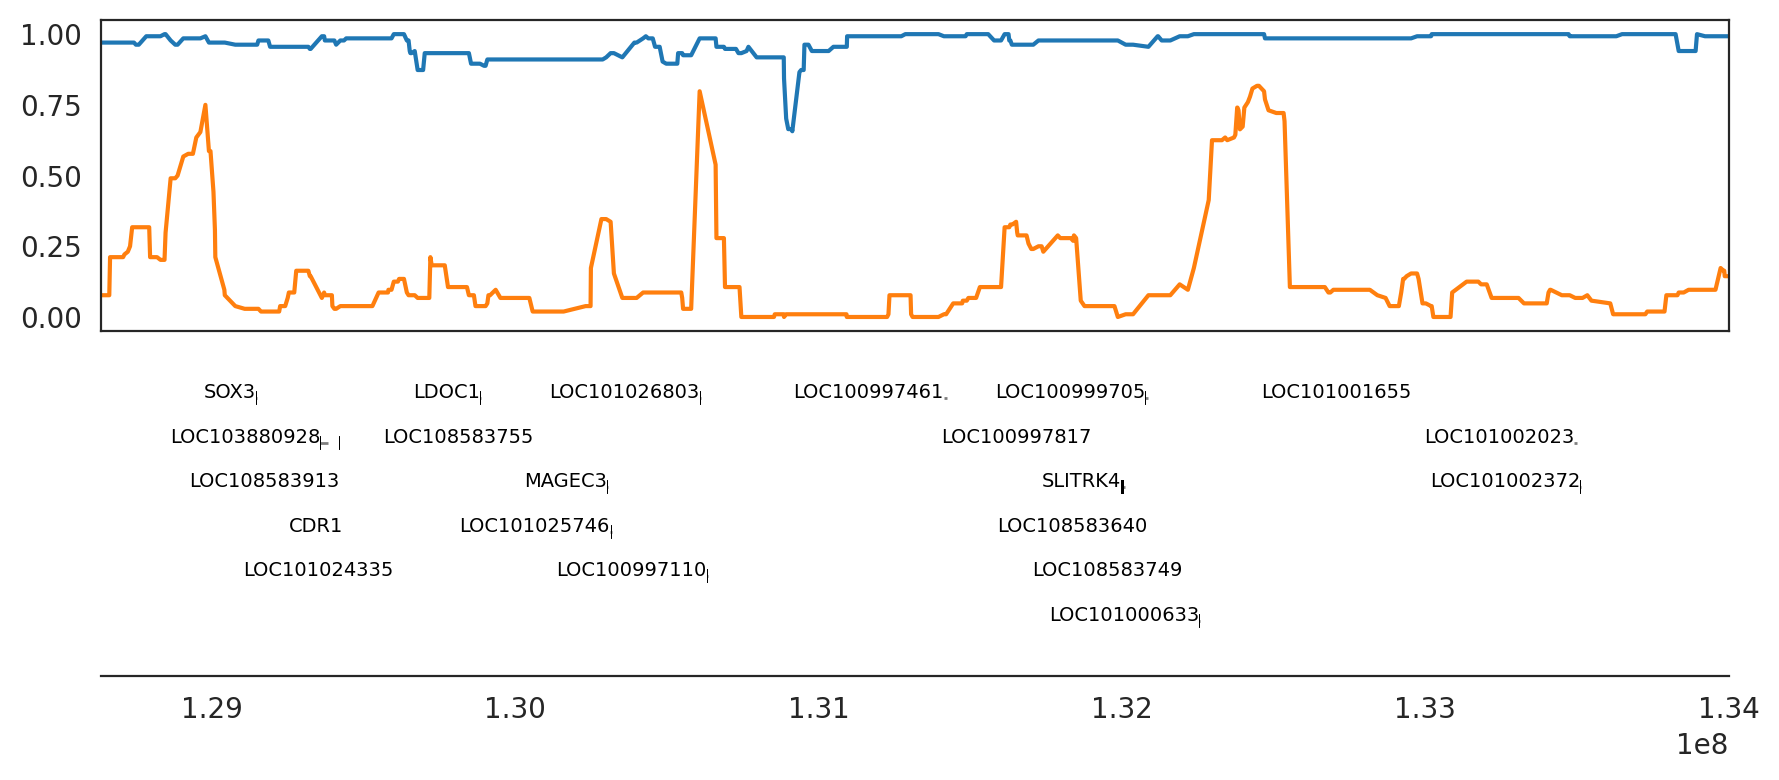

In [26]:
ax = gi.gene_plot('chrX', 129000000, 134000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

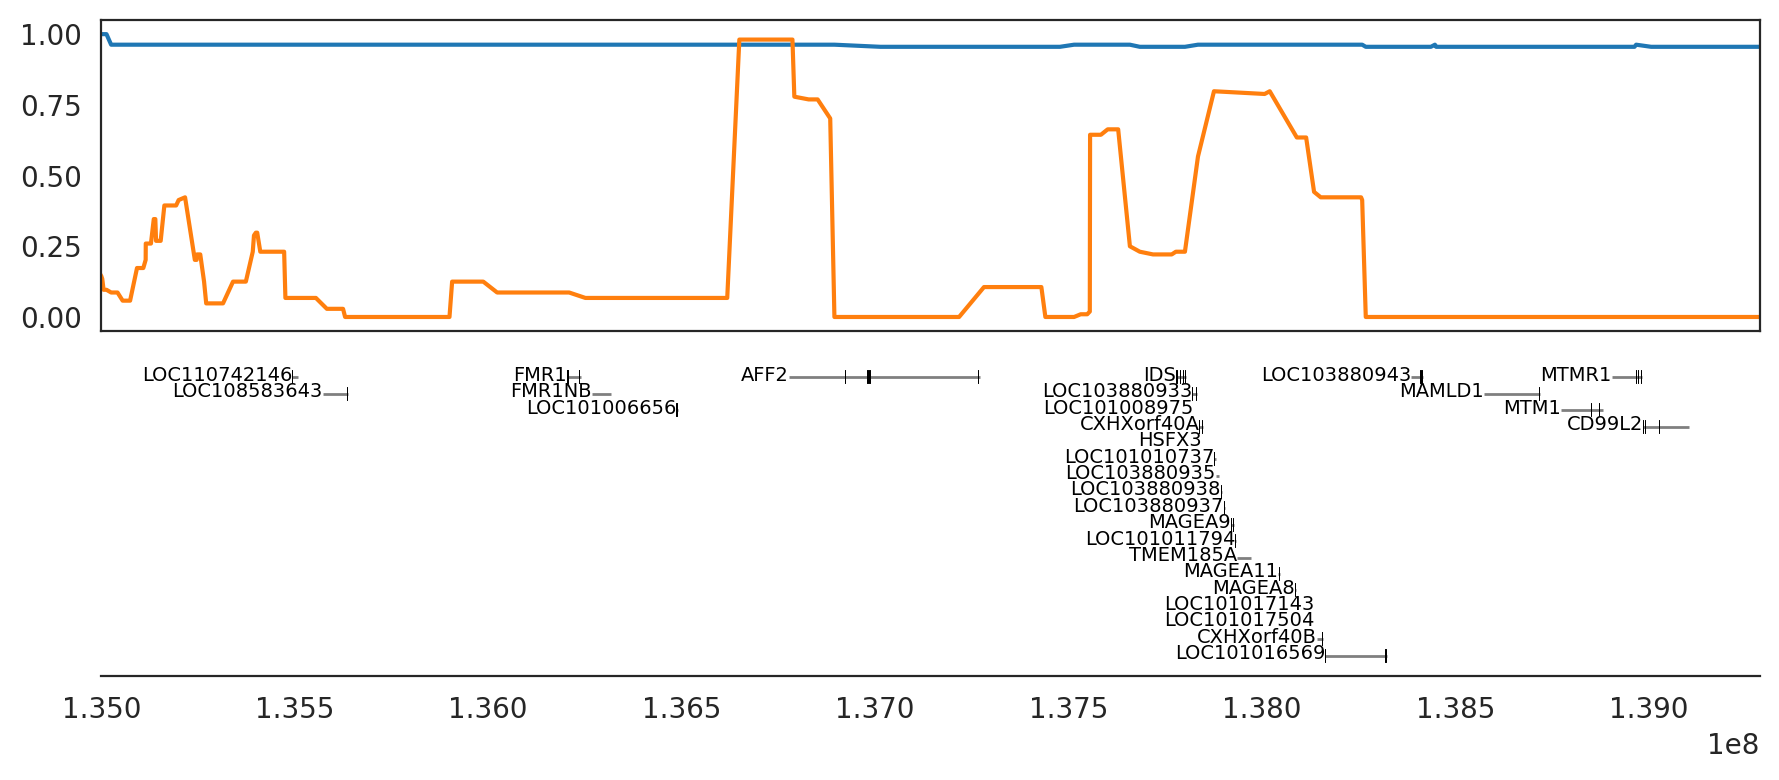

In [27]:
ax = gi.gene_plot('chrX', 135000000, 139000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

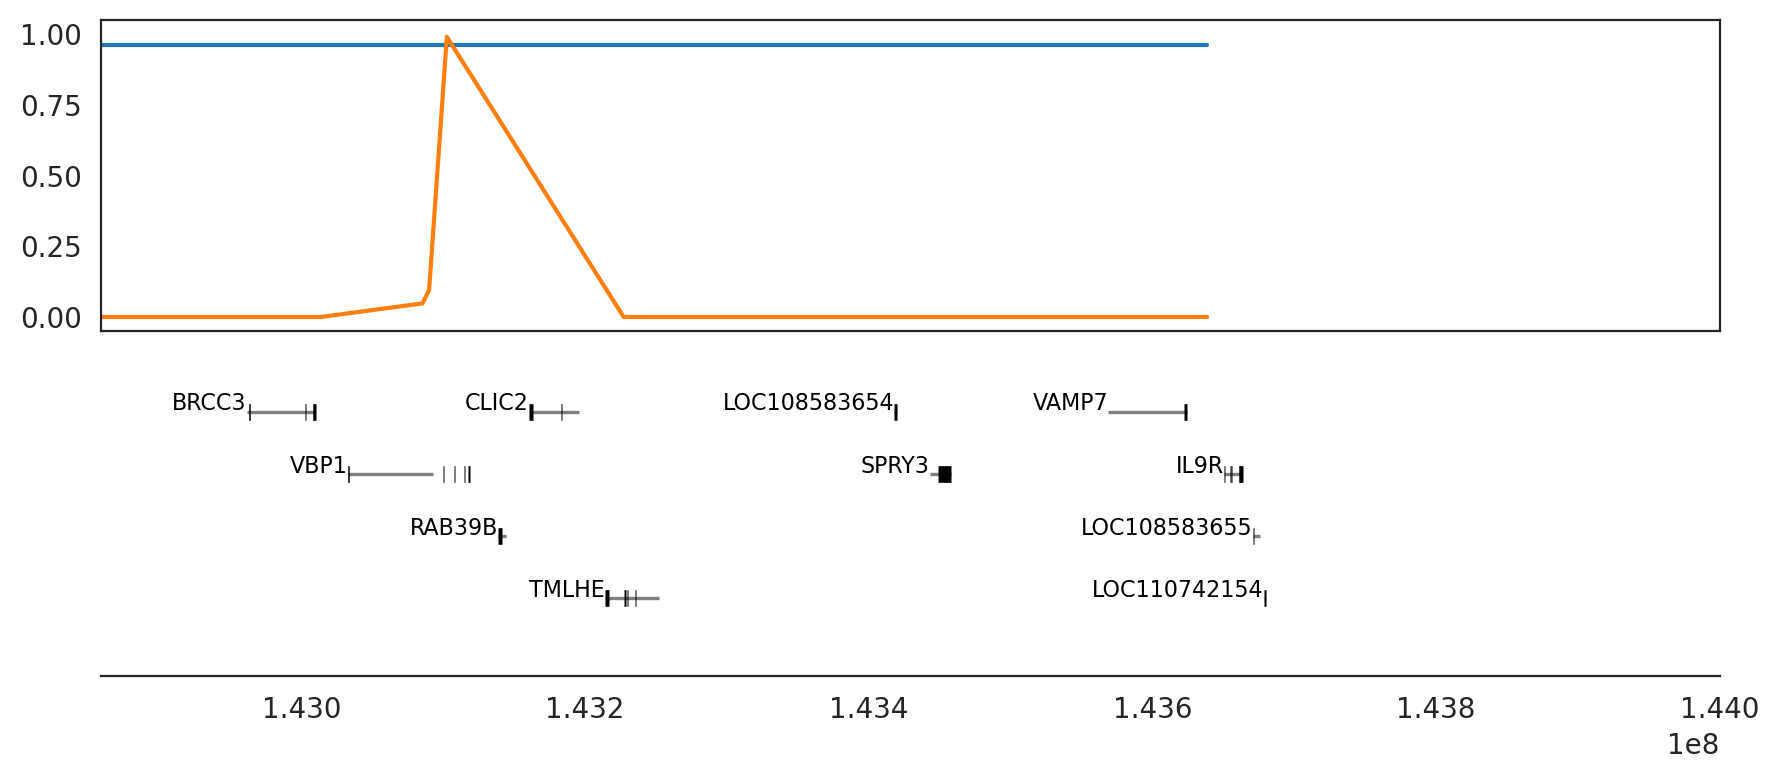

In [28]:
ax = gi.gene_plot('chrX', 143000000, 144000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

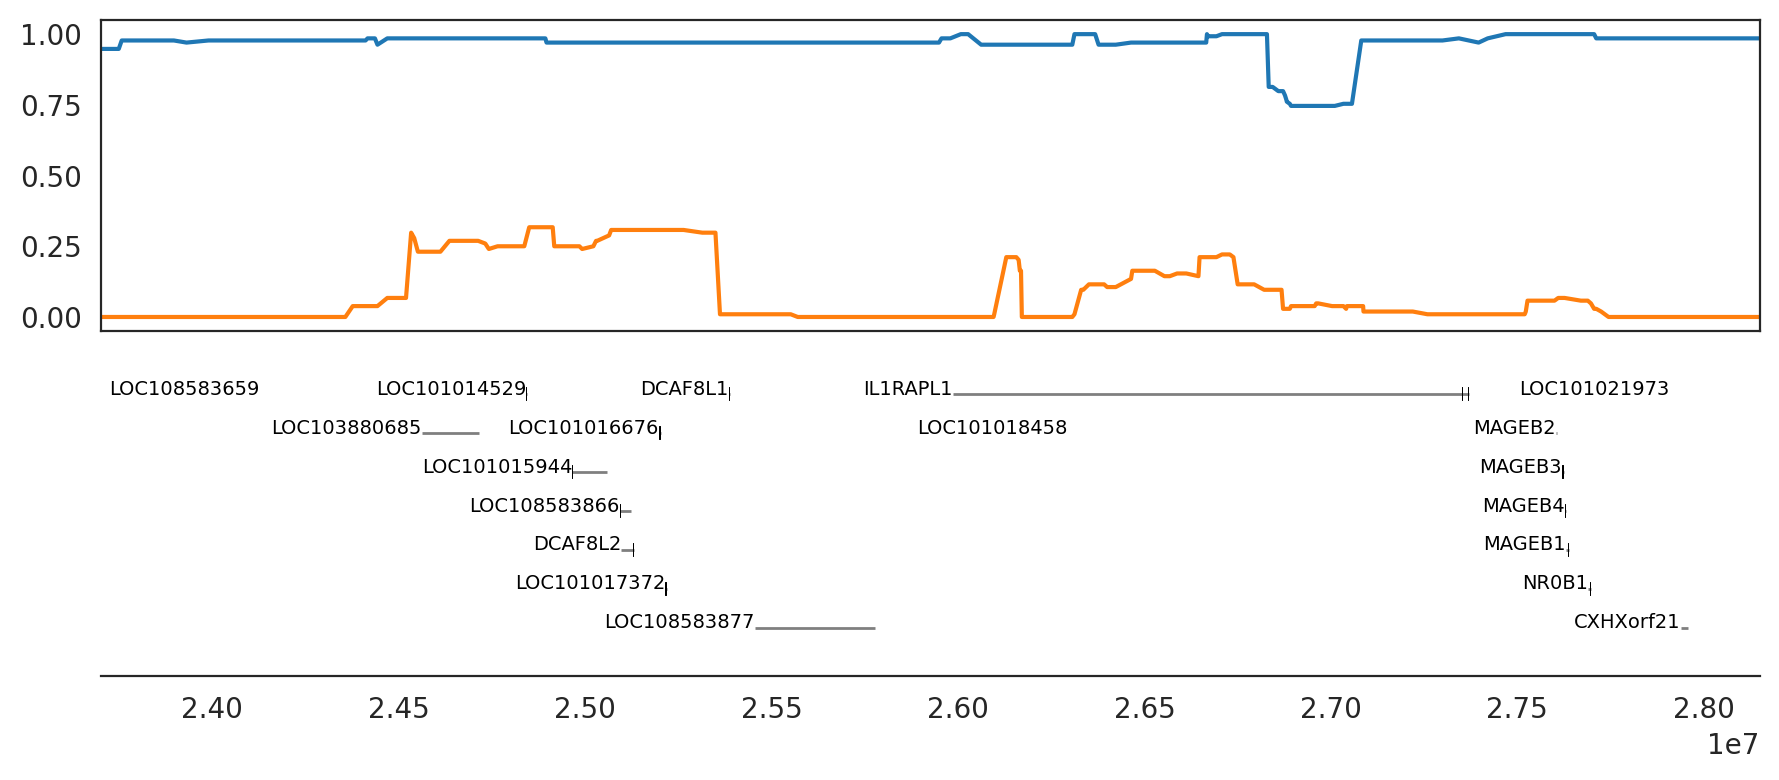

In [29]:
ax = gi.gene_plot('chrX', 24000000, 28000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

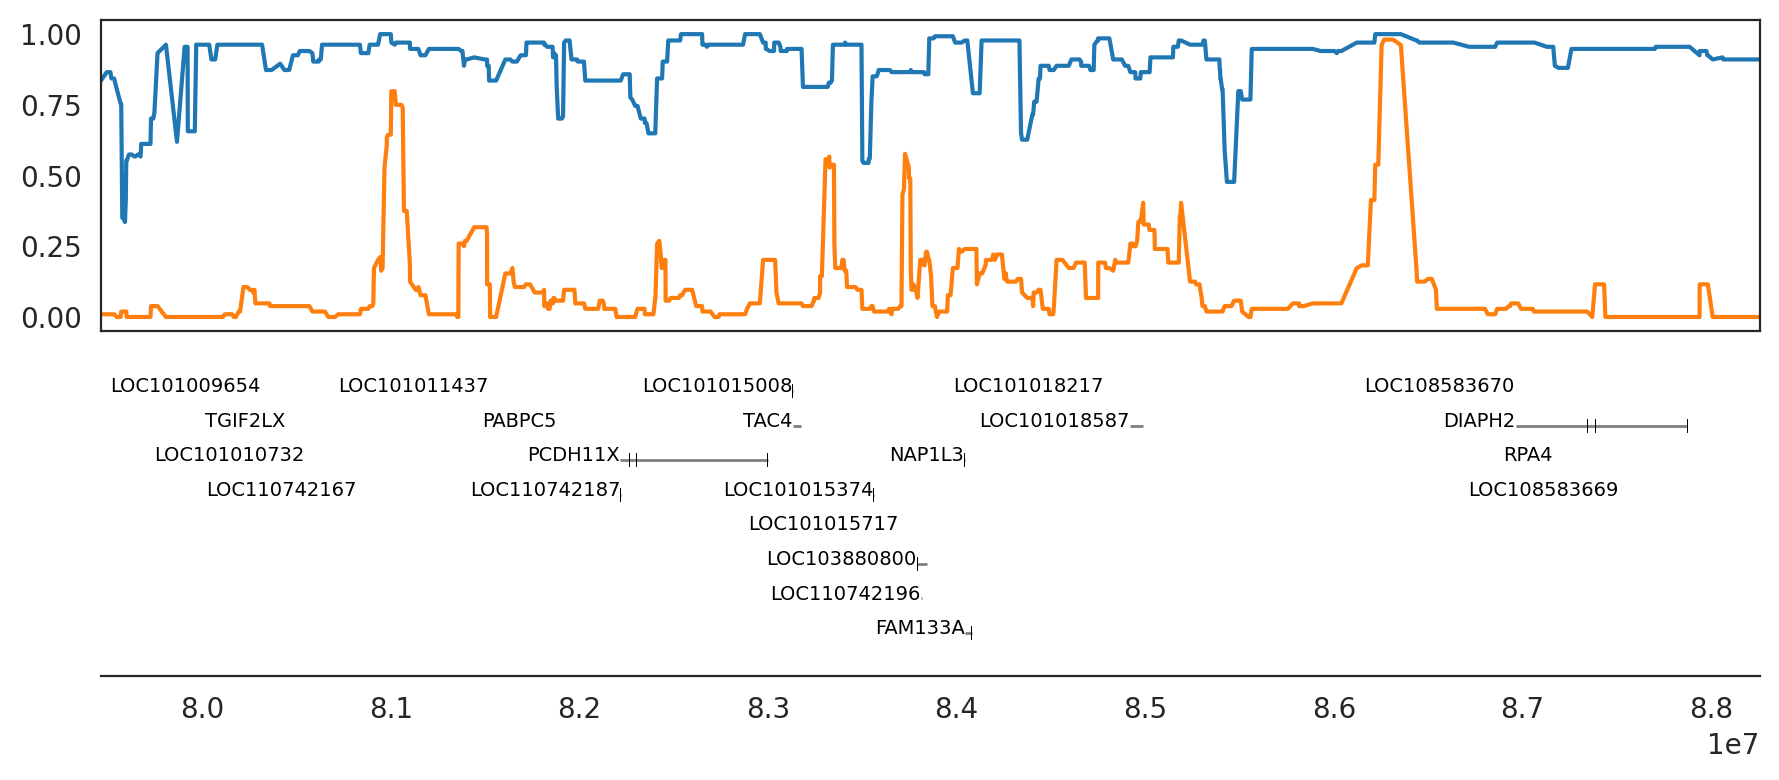

In [30]:
ax = gi.gene_plot('chrX', 80000000, 88000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(olive_tanzania.pos, olive_tanzania["n/s"])
ax.plot(eastern_yellow.pos, eastern_yellow["n/s"])
plt.tight_layout()

In [31]:
from scipy import stats
stats.spearmanr(olive_tanzania["n/s"], 1-eastern_yellow["n/s"])

SignificanceResult(statistic=-0.11460615215938336, pvalue=9.744630283573109e-23)

In [32]:
1-eastern_yellow["n/s"]

0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
7283    0.951923
7284    0.903846
7285    0.009615
7286    1.000000
7287    1.000000
Name: n/s, Length: 7288, dtype: float64

In [33]:
stats.spearmanr([-1, -1, 1], [1, 1, -1])

SignificanceResult(statistic=-1.0, pvalue=0.0)

<Axes: xlabel='n/s', ylabel='Count'>

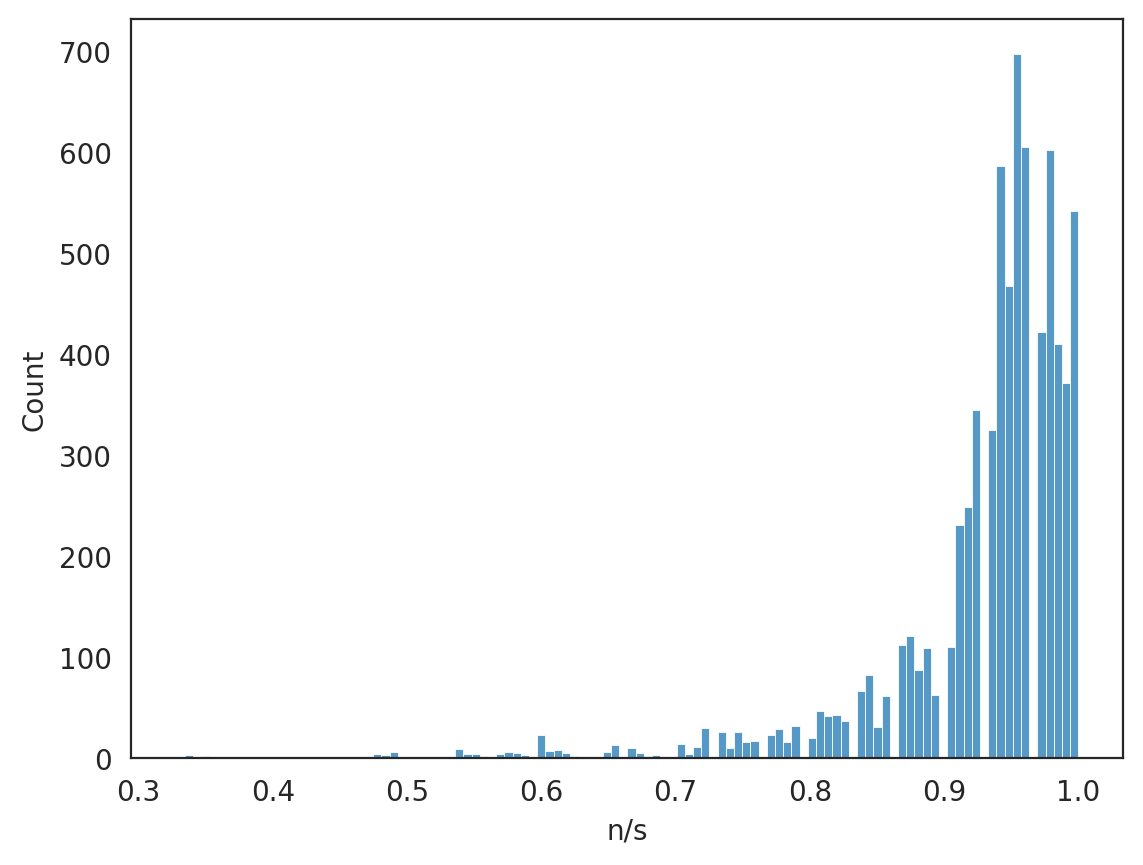

In [34]:
sns.histplot(x=olive_tanzania["n/s"])

[Text(0.5, 0, 'Yellow Major Parent Ancestry'),
 Text(0, 0.5, 'Olive Major Parent Ancestry')]

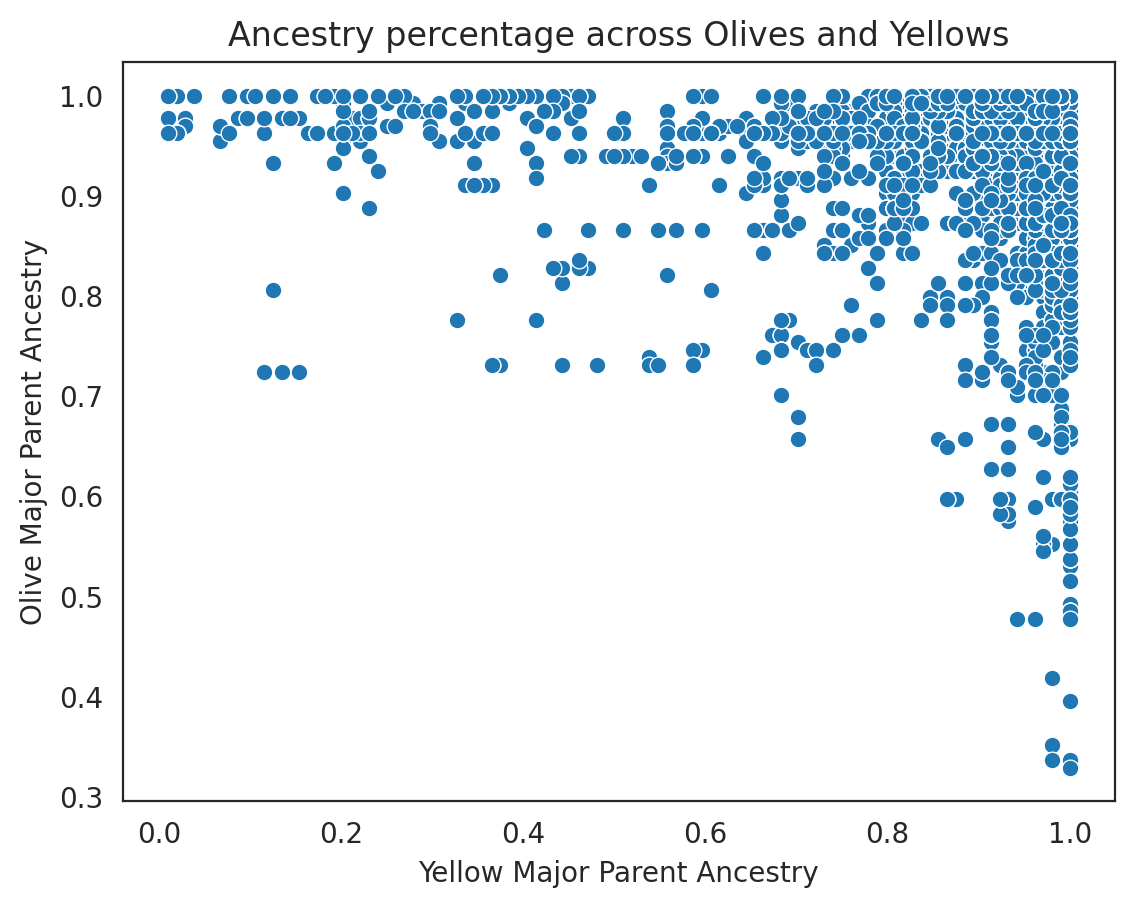

In [35]:
g = sns.scatterplot(y=olive_tanzania["n/s"], x=1-eastern_yellow["n/s"])
g.set(title="Ancestry percentage across Olives and Yellows")
g.set(xlabel="Yellow Major Parent Ancestry", ylabel="Olive Major Parent Ancestry")

Window stats

In [3]:
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")

In [4]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_eth = pd.concat(df_l)
mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

In [5]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"

df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    df_l.append(df)
window_df_tanz = pd.concat(df_l)
mean_window_df_tanz = window_df_tanz.groupby(["chrom", "individual", "start", "end"]).mean().reset_index()

In [6]:
mean_window_df_tanz

chrom individual      start        end  haplotype  north_sum
0        all_chrX    PD_0199          0     100000        0.5        0.0
1        all_chrX    PD_0199     100000     200000        0.5        0.0
2        all_chrX    PD_0199     200000     300000        0.5        0.0
3        all_chrX    PD_0199     300000     400000        0.5        0.0
4        all_chrX    PD_0199     400000     500000        0.5        0.0
...           ...        ...        ...        ...        ...        ...
4063352      chr9  Sci_30977  125300000  125400000        0.5   100000.0
4063353      chr9  Sci_30977  125400000  125500000        0.5   100000.0
4063354      chr9  Sci_30977  125500000  125600000        0.5   100000.0
4063355      chr9  Sci_30977  125600000  125700000        0.5   100000.0
4063356      chr9  Sci_30977  125700000  125800000        0.5    84130.0

[4063357 rows x 6 columns]

In [7]:
mapping_C_origin = dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.C_origin))
mapping_origin = dict(zip(meta_data_samples_sci.PGDP_ID, meta_data_samples_sci.Origin))
mean_window_df_eth["C_origin"] = mean_window_df_eth.individual.map(mapping_C_origin)
mean_window_df_eth["Origin"] = mean_window_df_eth.individual.map(mapping_origin)
mean_window_df_tanz["C_origin"] = mean_window_df_tanz.individual.map(mapping_C_origin)
mean_window_df_tanz["Origin"] = mean_window_df_tanz.individual.map(mapping_origin)


In [8]:
mean_window_df_eth

chrom individual      start        end  haplotype  north_sum  \
0        all_chrX    PD_0228          0     100000        0.5        0.0   
1        all_chrX    PD_0228     100000     200000        0.5        0.0   
2        all_chrX    PD_0228     200000     300000        0.5        0.0   
3        all_chrX    PD_0228     300000     400000        0.5        0.0   
4        all_chrX    PD_0228     400000     500000        0.5        0.0   
...           ...        ...        ...        ...        ...        ...   
1290015      chr9  Sci_30977  125300000  125400000        0.5        0.0   
1290016      chr9  Sci_30977  125400000  125500000        0.5        0.0   
1290017      chr9  Sci_30977  125500000  125600000        0.5        0.0   
1290018      chr9  Sci_30977  125600000  125700000        0.5        0.0   
1290019      chr9  Sci_30977  125700000  125800000        0.5        0.0   

                               C_origin            Origin  
0        Cynocephalus, Western Tanzania  Mahale, Tanzania  
1        Cynocephalus, Western Tanzania  Mahale, Tanzania  
2        Cynocephalus, Western Tanzania  Mahale, Tanzania  
3        Cynocephalus, Western Tanzania  Mahale, Tanzania  
4        Cynocephalus, Western Tanzania  Mahale, Tanzania  
...                                 ...               ...  
1290015                   Anubis, Kenya   Aberdare, Kenya  
1290016                   Anubis, Kenya   Aberdare, Kenya  
1290017                   Anubis, Kenya   Aberdare, Kenya  
1290018                   Anubis, Kenya   Aberdare, Kenya  
1290019                   Anubis, Kenya   Aberdare, Kenya  

[1290020 rows x 8 columns]

In [9]:
cyno_west = mean_window_df_tanz.loc[(mean_window_df_tanz.chrom == "all_chrX") &
                        (mean_window_df_tanz.C_origin.isin(["Cynocephalus, Western Tanzania"]))].groupby(["start", "C_origin"])["north_sum"].mean().reset_index()
ruaha_gombe = mean_window_df_tanz.loc[(mean_window_df_tanz.chrom == "all_chrX") &
                        (mean_window_df_tanz.Origin.isin(["Ruaha, Tanzania", "Gombe, Tanzania"]))].groupby(["start", "C_origin"])["north_sum"].mean().reset_index()
gog = mean_window_df_eth.loc[(mean_window_df_eth.chrom == "all_chrX") &
                        (mean_window_df_eth.Origin.isin(["Gog Woreda, Gambella region, Ethiopia"]))].groupby(["start", "C_origin"])["north_sum"].mean().reset_index()

In [10]:
concat_df = pd.concat([cyno_west, ruaha_gombe, gog])

In [11]:
concat_df["Minor Parent Ancestry"] = [(100000-x)/100000 if y == ("Anubis, Tanzania")
                                             else x/100000 for x, y in zip(concat_df["north_sum"],
                                                                        concat_df["C_origin"])]

<Axes: xlabel='Minor Parent Ancestry', ylabel='Count'>

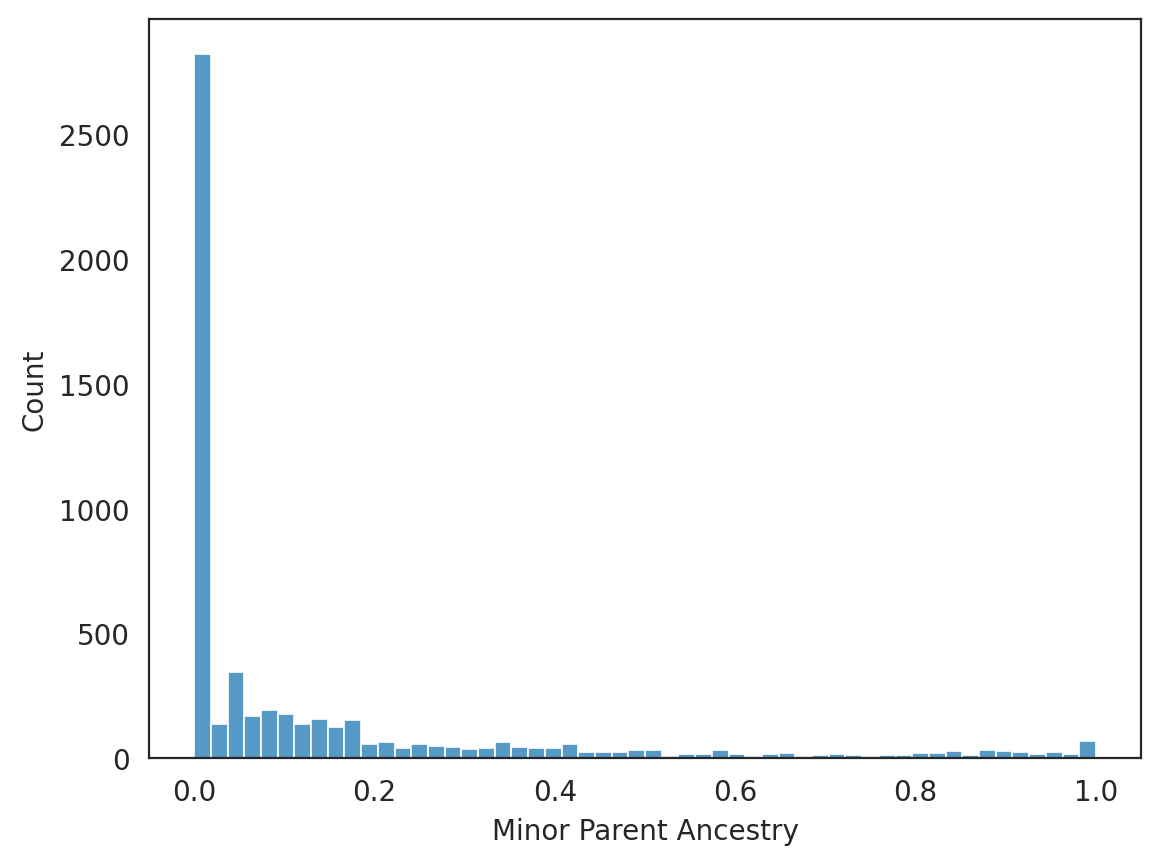

In [12]:
sns.histplot(concat_df["Minor Parent Ancestry"])

In [13]:
c_r_g_df_x = c_r_g_df.loc[c_r_g_df.chrom == "chrX"]
c_r_g_df_x

chrom      start  callable_frac        end          cM      end_cM  \
25945  chrX          0        0.04690     100000    0.000000    0.982930   
25946  chrX     100000        0.64769     200000    0.982930    1.322269   
25947  chrX     200000        0.95965     300000    1.322269    1.504651   
25948  chrX     300000        0.94918     400000    1.504651    1.703484   
25949  chrX     400000        0.78703     500000    1.703484    1.748264   
...     ...        ...            ...        ...         ...         ...   
27377  chrX  143200000        0.66998  143300000  126.757529  126.783155   
27378  chrX  143300000        0.90454  143400000  126.783155  126.816893   
27379  chrX  143400000        0.78855  143500000  126.816893  126.844878   
27380  chrX  143500000        0.83590  143600000  126.844878  126.920225   
27381  chrX  143600000        0.60401  143691566  126.920225  127.257801   

       average_cM_window                                              genes  \
25945       9.829296e-06  ['CD99', 'CD99', 'CD99', 'CD99', 'CD99', 'XG',...   
25946       3.393394e-06  ['XG', 'XG', 'XG', 'XG', 'XG', 'XG', 'XG', 'XG...   
25947       1.823823e-06  ['GYG2', 'GYG2', 'GYG2', 'GYG2', 'GYG2', 'GYG2...   
25948       1.988331e-06  ['ARSE', 'ARSE', 'ARSE', 'ARSE', 'ARSE', 'ARSE...   
25949       4.477935e-07                   ['ARSF', 'ARSF', 'ARSF', 'ARSF']   
...                  ...                                                ...   
27377       2.562611e-07      ['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']   
27378       3.373798e-07               ['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']   
27379       2.798504e-07                                          ['SPRY3']   
27380       7.534706e-07                                          ['VAMP7']   
27381       3.686700e-06                                          ['VAMP7']   

       genic  
25945   True  
25946   True  
25947   True  
25948   True  
25949   True  
...      ...  
27377   True  
27378   True  
27379   True  
27380   True  
27381   True  

[1437 rows x 9 columns]

In [14]:
gene_df = concat_df.merge(c_r_g_df_x, on=["start"])
gene_df = gene_df.loc[gene_df.callable_frac > 0.9]

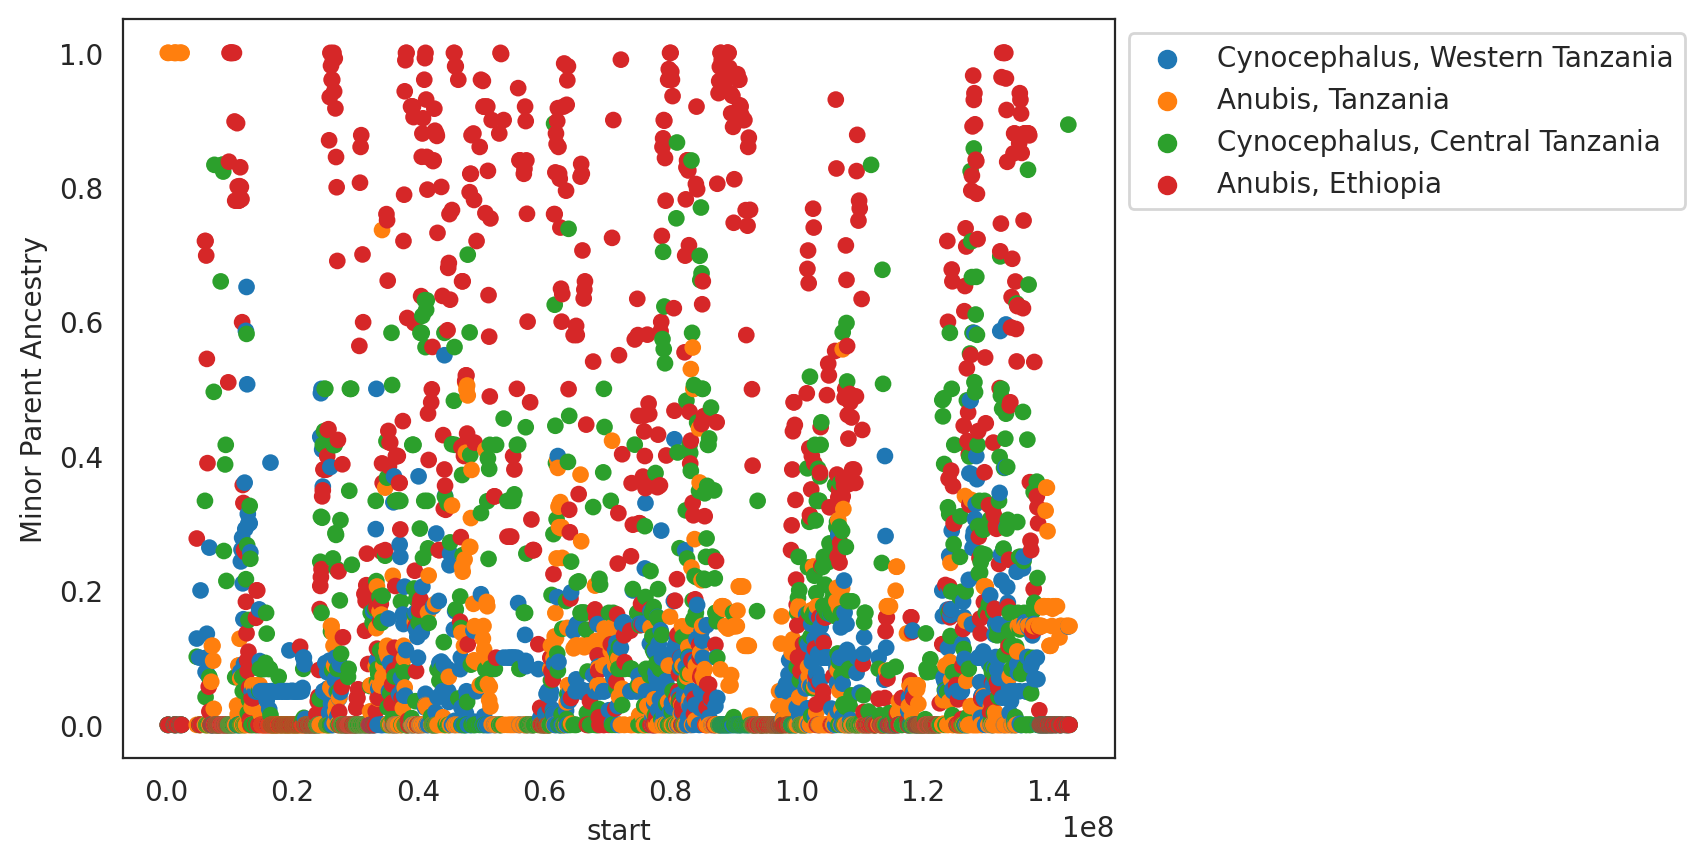

In [35]:
g = sns.scatterplot(gene_df, x="start", y="Minor Parent Ancestry", hue="C_origin", linewidth=0)
g.legend(bbox_to_anchor=(1, 1))

In [18]:
mean_MPA = gene_df.groupby(["start"])["Minor Parent Ancestry"].mean().reset_index()#.sort_values("Minor Parent Ancestry")

<Axes: xlabel='start', ylabel='Minor Parent Ancestry'>

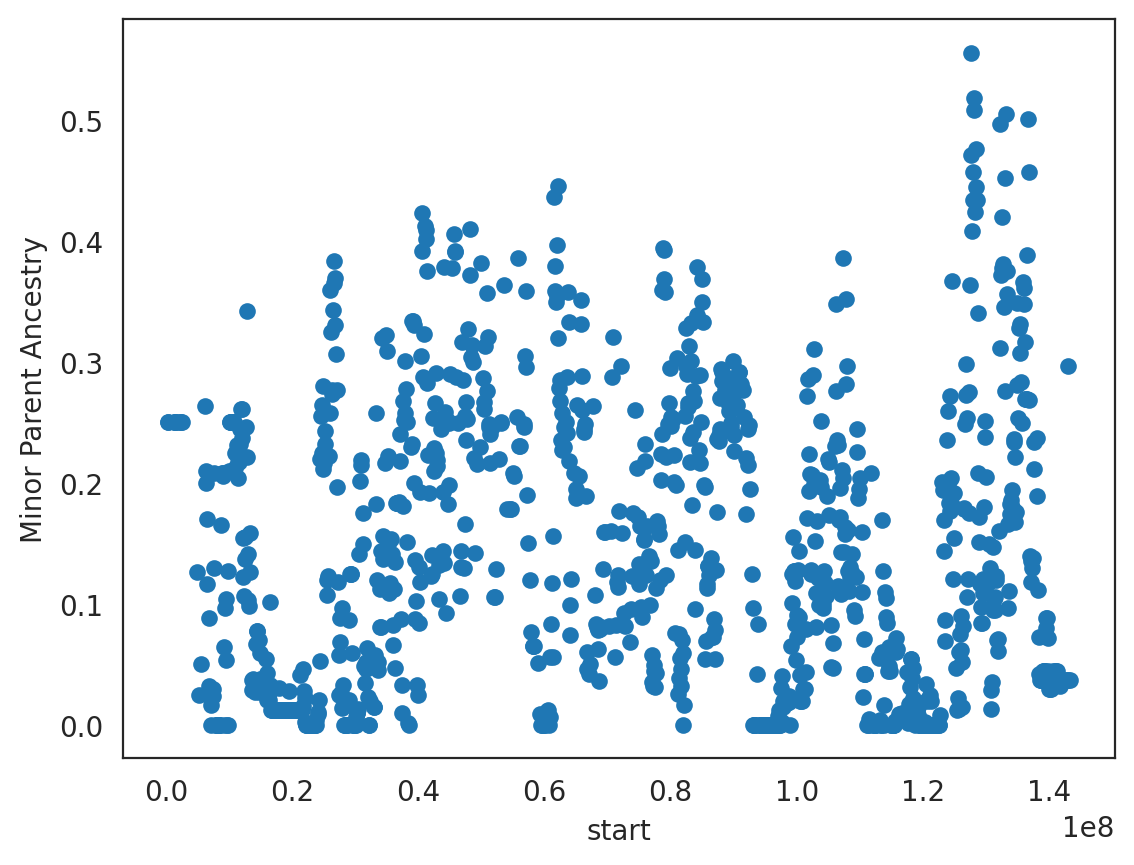

In [36]:
sns.scatterplot(mean_MPA, x="start", y="Minor Parent Ancestry", linewidth=0)

In [20]:
mean_MPA.sort_values("Minor Parent Ancestry")

start  Minor Parent Ancestry
844   115200000               0.000000
693    96900000               0.000000
692    96800000               0.000000
691    96700000               0.000000
690    96600000               0.000000
...         ...                    ...
1028  136700000               0.500761
996   133200000               0.505150
951   128200000               0.508237
950   128100000               0.518699
946   127700000               0.555657

[1075 rows x 2 columns]

In [21]:
import itertools
mean_MPA["low_cut"] = mean_MPA["Minor Parent Ancestry"] < np.quantile(mean_MPA["Minor Parent Ancestry"], 0.25)
mean_MPA["low_streak"] = [i for k, g in itertools.groupby(mean_MPA["low_cut"]) for i in range(len(list(g)))]

In [22]:
np.quantile(mean_MPA["Minor Parent Ancestry"], 0.25)

0.03247054534313726

[Text(0.5, 1.0, 'Low MPA runs'),
 Text(0, 0.5, 'Run Length'),
 Text(0.5, 0, 'Window')]

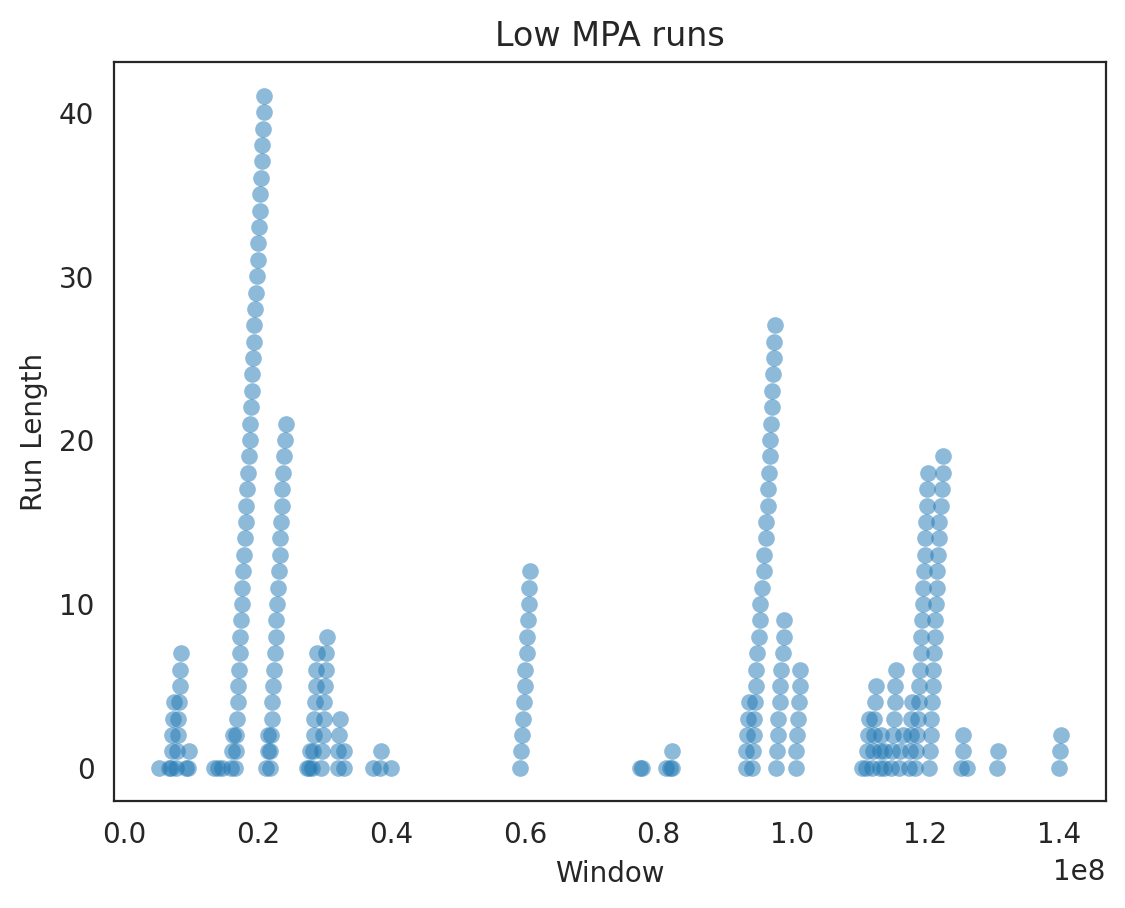

In [23]:
g = sns.scatterplot(mean_MPA.loc[mean_MPA.low_cut == True], x="start", y="low_streak", alpha=0.5, linewidth=0)
g.set(title="Low MPA runs", ylabel="Run Length", xlabel="Window")

In [24]:
mean_MPA.loc[mean_MPA.low_cut == True].sort_values("low_streak")

start  Minor Parent Ancestry  low_cut  low_streak
10    5200000               0.025000     True           0
575  82000000               0.000002     True           0
572  81700000               0.032353     True           0
567  81200000               0.025607     True           0
537  77500000               0.031042     True           0
..        ...                    ...      ...         ...
141  20600000               0.012501     True          37
142  20700000               0.012500     True          38
143  20800000               0.012501     True          39
144  20900000               0.012500     True          40
145  21000000               0.012500     True          41

[269 rows x 4 columns]

In [25]:
gene_df.C_origin.unique()

array(['Cynocephalus, Western Tanzania', 'Anubis, Tanzania',
       'Cynocephalus, Central Tanzania', 'Anubis, Ethiopia'], dtype=object)

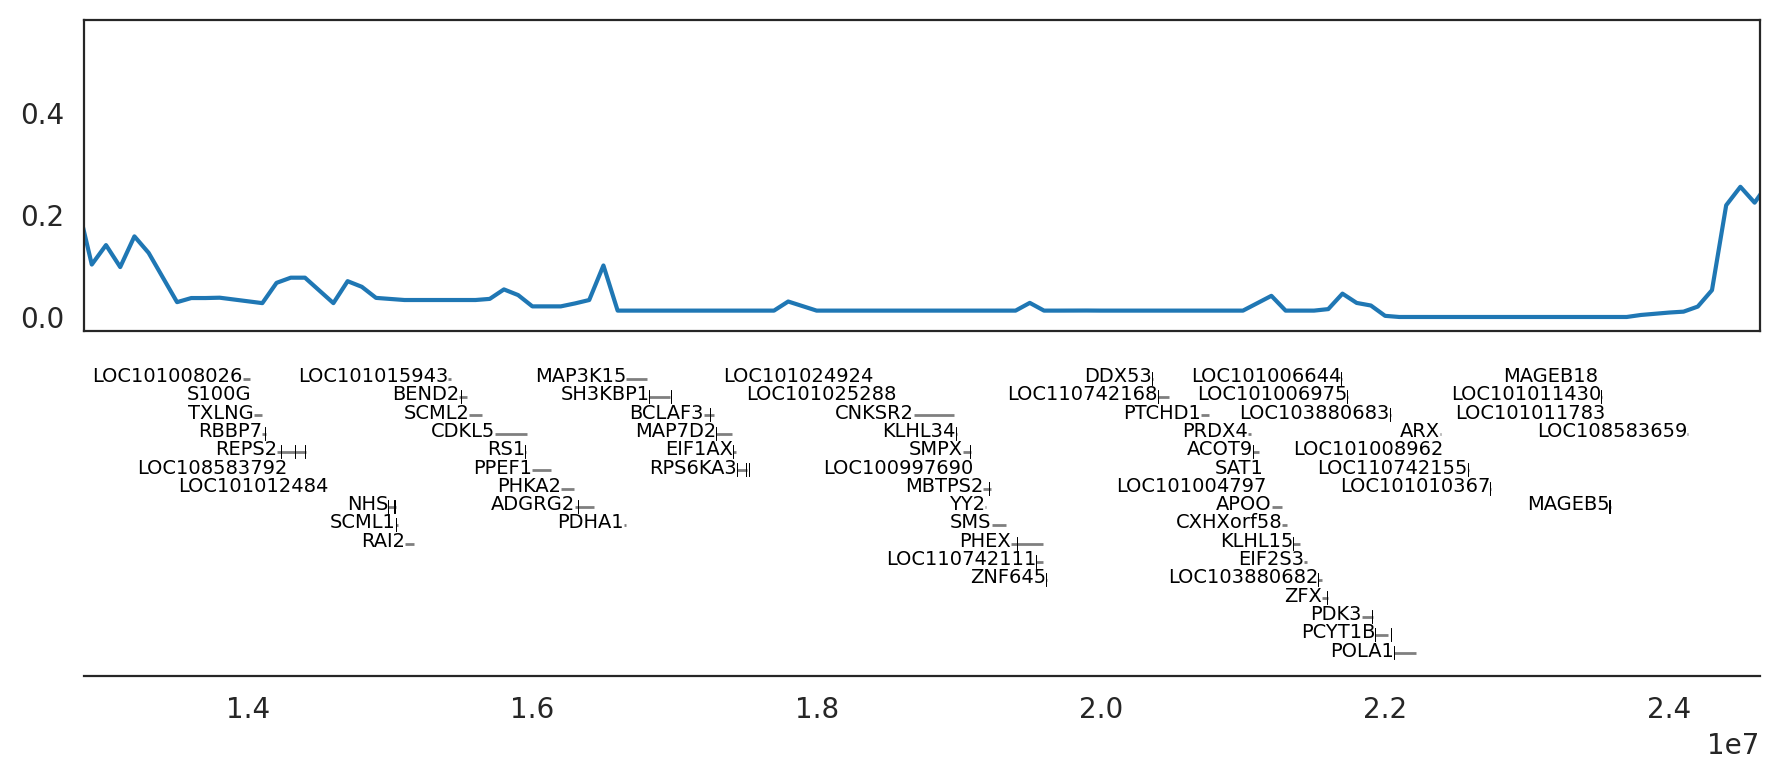

In [26]:
ax = gi.gene_plot('chrX', 14000000, 24500000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mean_MPA.start, mean_MPA["Minor Parent Ancestry"])
plt.tight_layout()

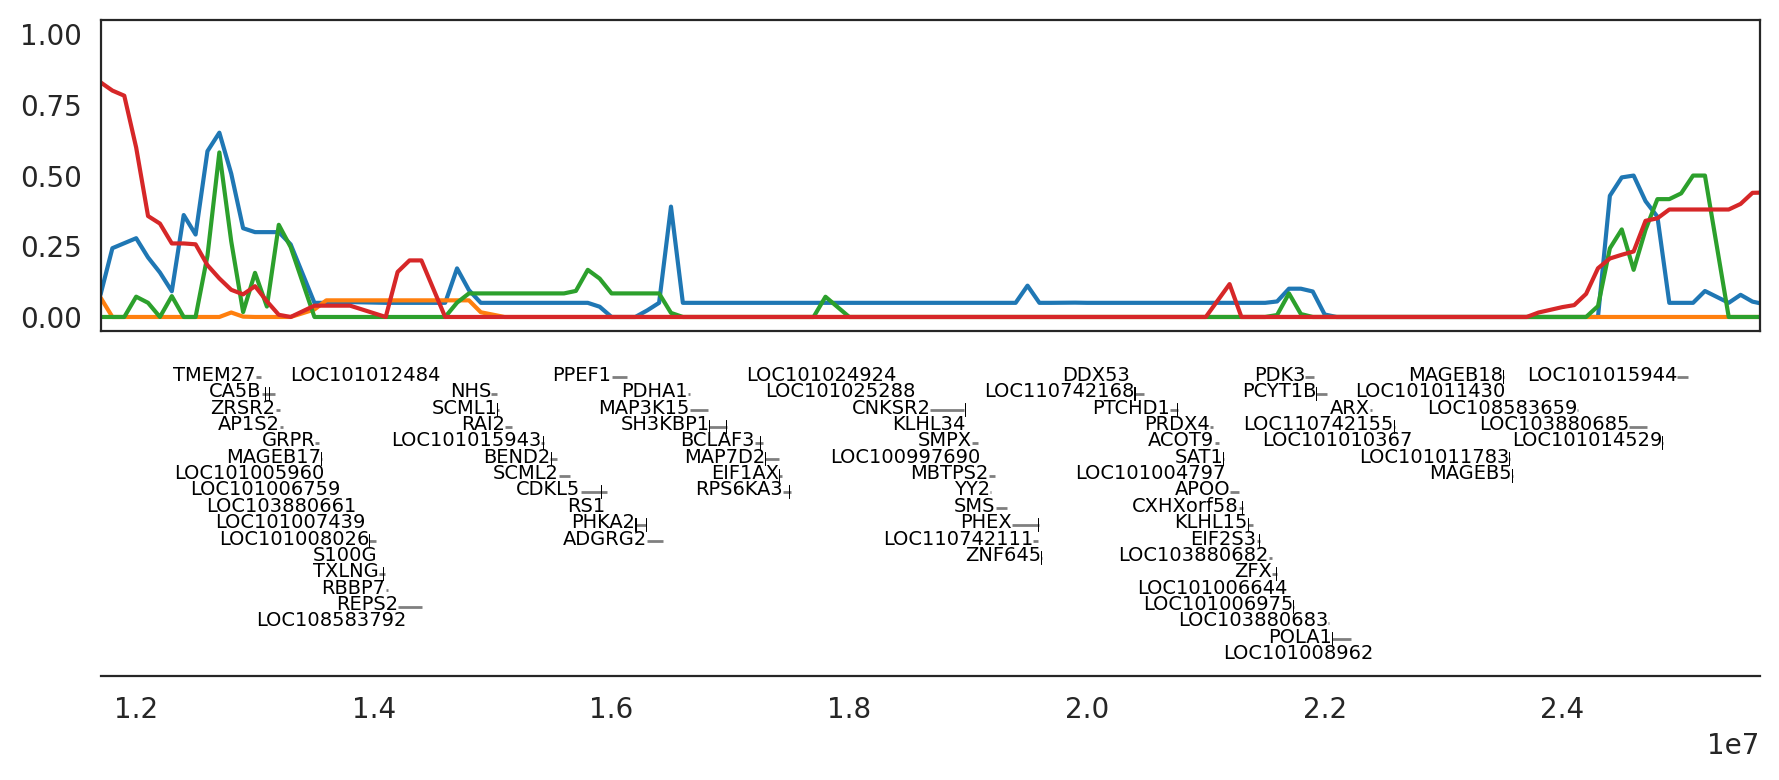

In [27]:
ax = gi.gene_plot('chrX', 13000000, 25000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))

for o in gene_df.C_origin.unique():
    o_df = gene_df.loc[gene_df.C_origin == o]
    ax.plot(o_df.start, o_df["Minor Parent Ancestry"])
plt.tight_layout()

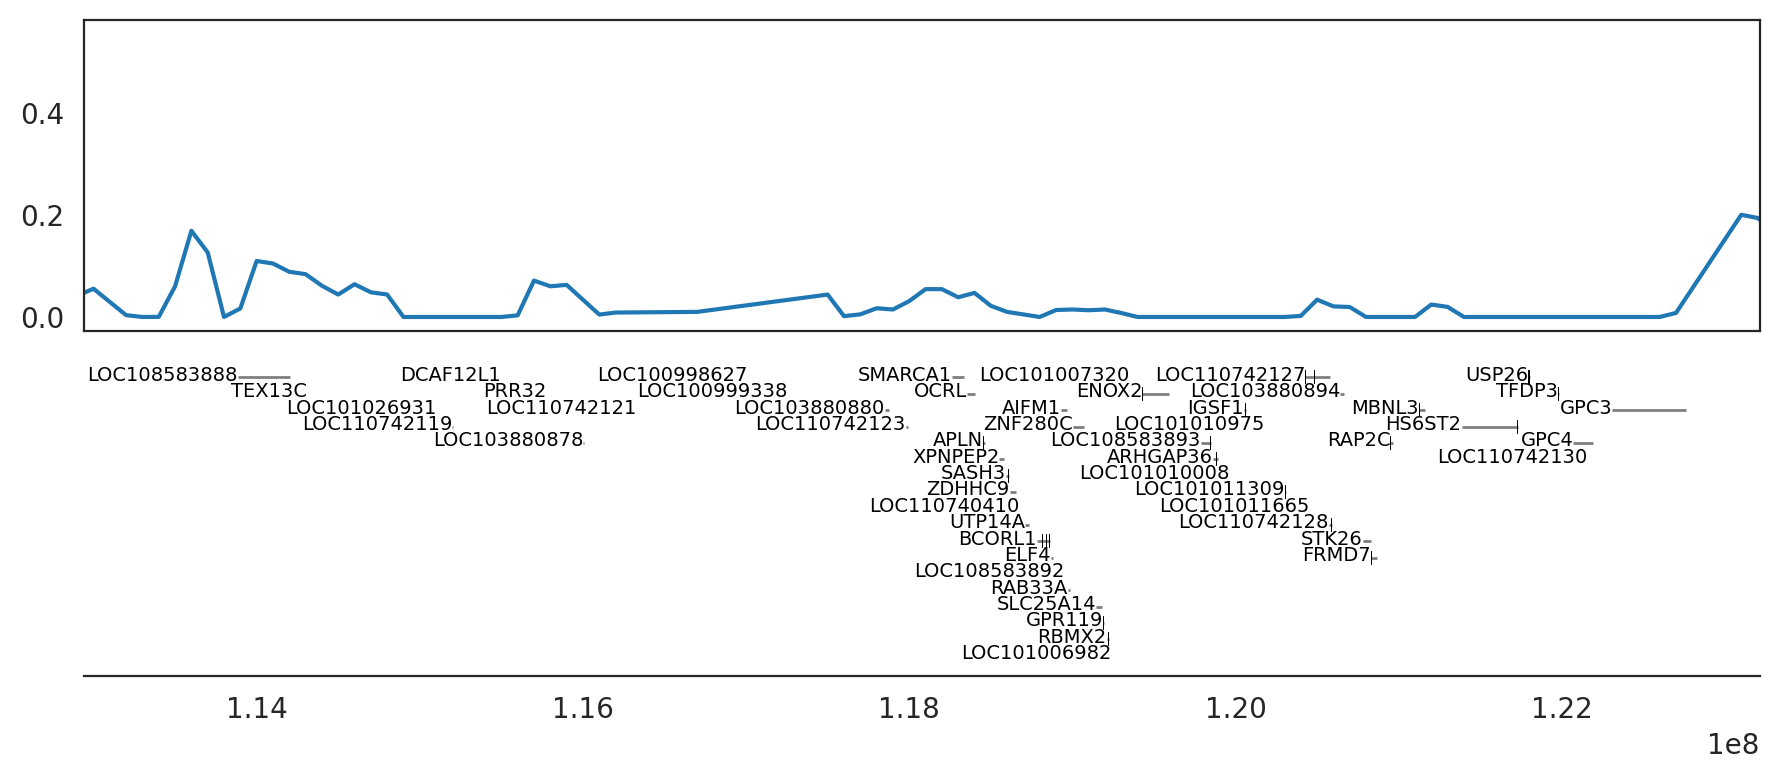

In [28]:
ax = gi.gene_plot('chrX', 114000000, 122600000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mean_MPA.start, mean_MPA["Minor Parent Ancestry"])
plt.tight_layout()

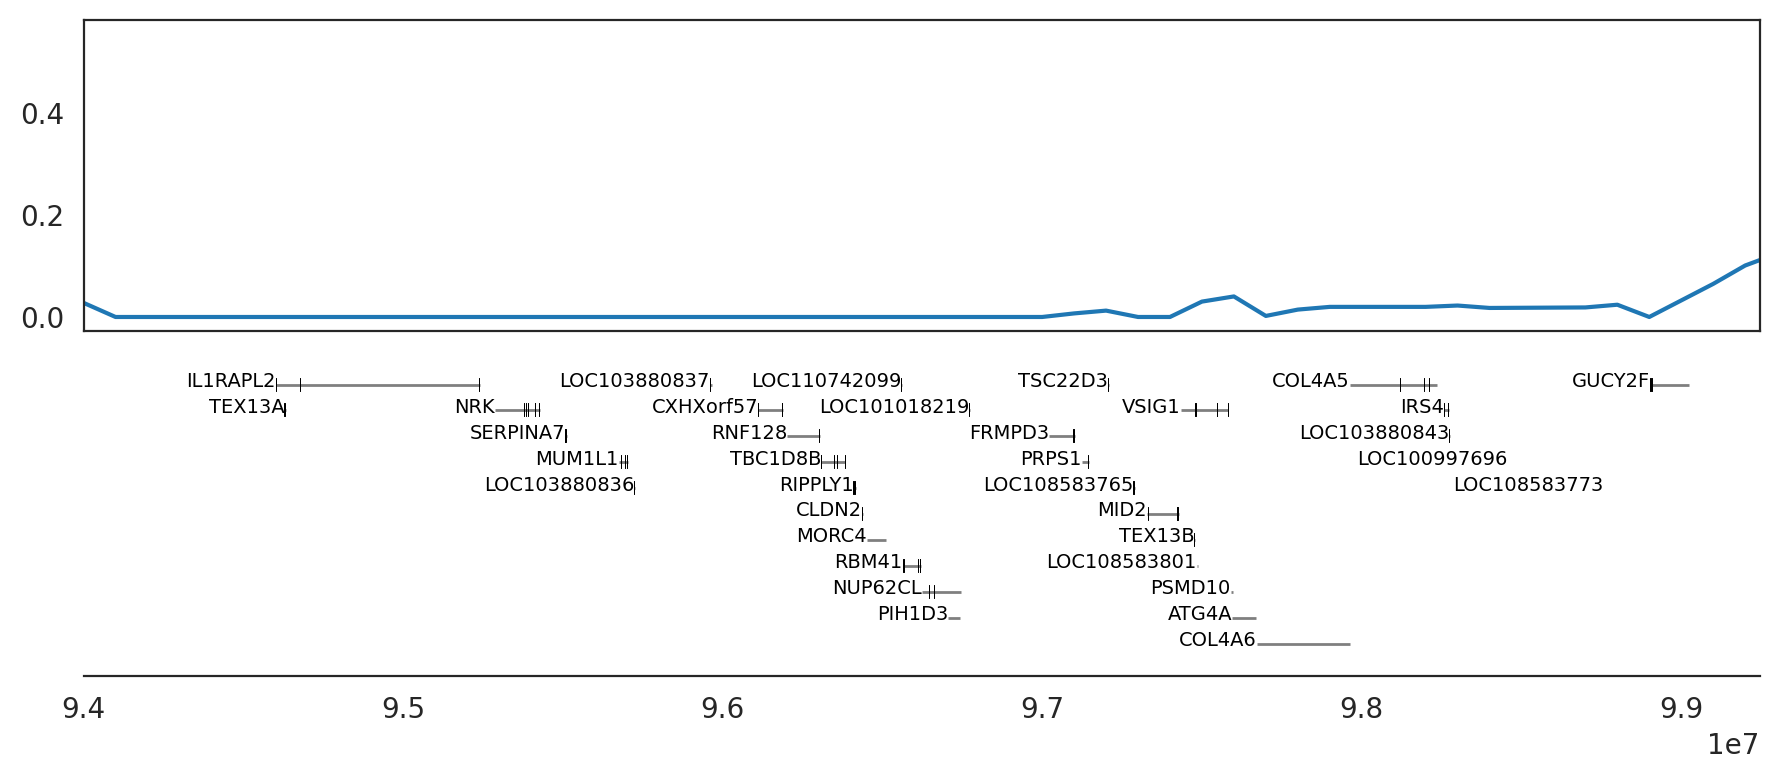

In [29]:
ax = gi.gene_plot('chrX', 94000000, 99000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
#ax.plot(data=olive_mean.rolling(roll_size).mean(), x="windows", y="percent_north")
ax.plot(mean_MPA.start, mean_MPA["Minor Parent Ancestry"])
plt.tight_layout()

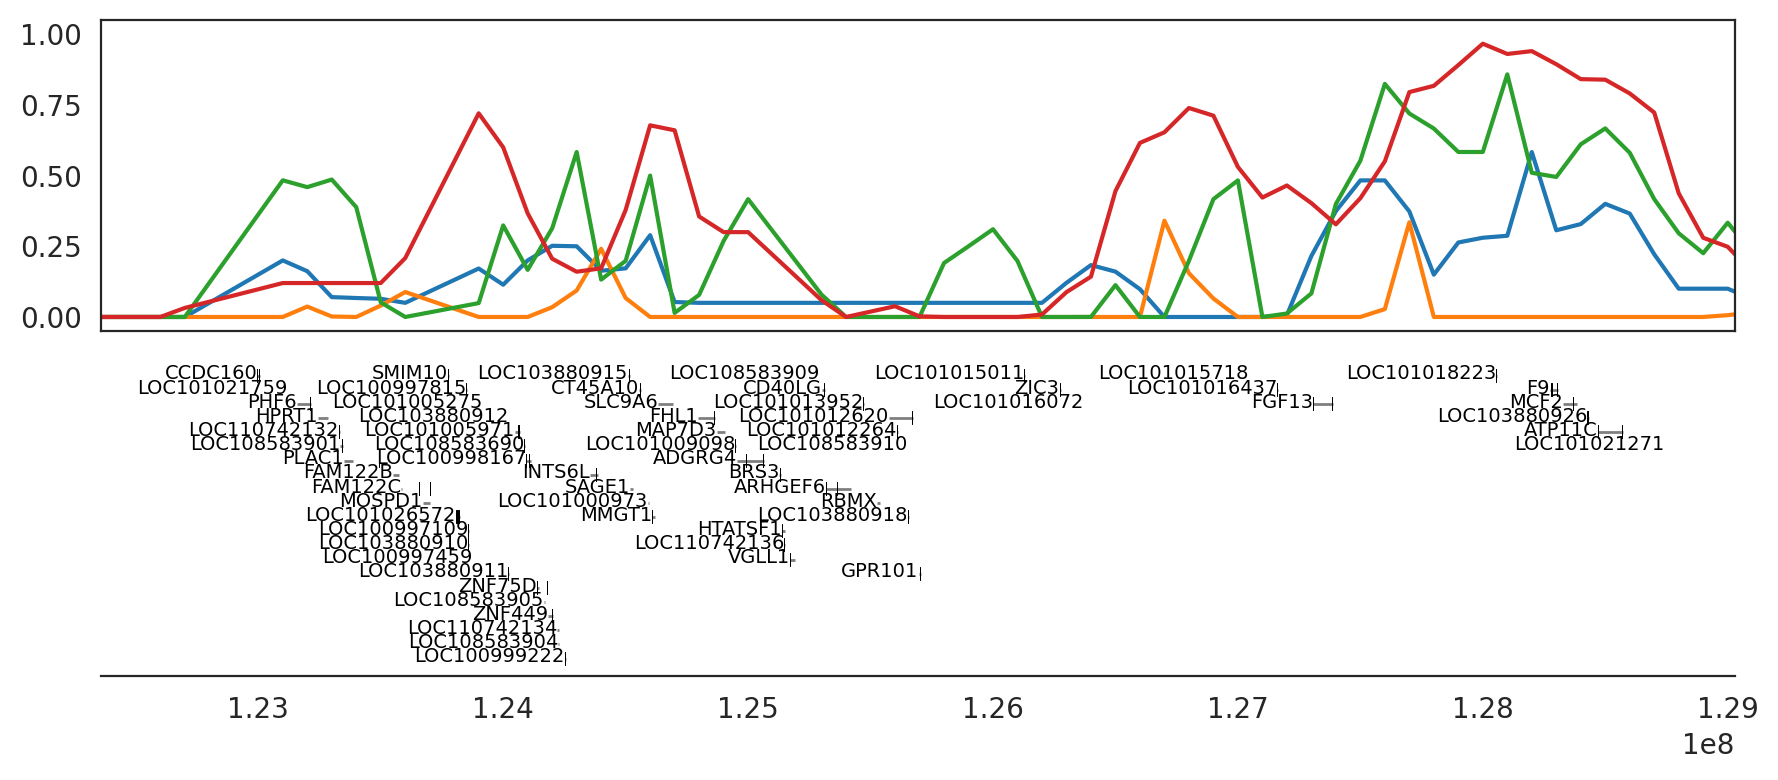

In [37]:
ax = gi.gene_plot('chrX', 123000000, 129000000, assembly='papAnu4', exact_exons=True, figsize=(9, 4))
roll_size = 1
for o in gene_df.C_origin.unique():
    o_df = gene_df.loc[gene_df.C_origin == o]
    ax.plot(o_df.start, o_df["Minor Parent Ancestry"])
plt.tight_layout()